In [53]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import logging
import pickle
from PySONIC.utils import logger
from PySONIC.neurons import getPointNeuron
from PySONIC.core import NeuronalBilayerSonophore
from PySONIC.core.drives import *
from PySONIC.core.protocols import *
from PySONIC.core.batches import Batch
from PySONIC.plt import GroupedTimeSeries
logger.setLevel(logging.INFO)

In [2]:
def Qm_to_Vm_norm(Qm):
    return Qm * 1e5

def detect_spikes(t_ms, Vm_mV):
    spike_idxs = Vm_mV <= -80                  # Check for instances of reset voltage
    n_spikes = np.sum(spike_idxs)              # Count spikes
    
    if n_spikes == 0:
        return np.nan, 0
    
    spike_times = t_ms[spike_idxs]
    spike_latency = spike_times[0]
    t_total_s = (t_ms[-1] - t_ms[0]) * 1e-3    # Calculate total time elapsed
    fr_hz = n_spikes / t_total_s               # Calculate overall firing rate
    return spike_latency, fr_hz

In [3]:
# Define point-neuron model
lin_h_pn = getPointNeuron('linear_HNap')
lin_ks_pn = getPointNeuron('linear_KsNap')
quad_h_pn = getPointNeuron('quadratic_HNap')
quad_ks_pn = getPointNeuron('quadratic_KsNap')

# Figure 1

In [4]:
# Define stimulus drive and time protocol
curr1 = 1 # mA/m^2
drive1 = ElectricDrive(curr1)

curr2 = -1 # mA/m^2
drive2 = ElectricDrive(curr2)

stim_dur = 500e-3
t_start = 200e-3
pp = PulsedProtocol(tstim=stim_dur, toffset=100e-3, tstart=t_start)

# Run simulations and plot results
data1, _ = quad_h_pn.simulate(drive1, pp)
data2, _ = quad_h_pn.simulate(drive2, pp)
t1 = np.array(data1.t)
t2 = np.array(data2.t)
t1_idxs = (t1 >= t_start) & (t1 <= (t_start + stim_dur))
t2_idxs = (t2 >= t_start) & (t2 <= (t_start + stim_dur))
t1_corr = (t1[t1_idxs] - t_start) * 1e3
t2_corr = (t2[t2_idxs] - t_start) * 1e3
Vm1 = Qm_to_Vm_norm(data1.Qm)
Vm2 = Qm_to_Vm_norm(data2.Qm)

 14/07/2025 00:12:15: QuadraticHNap: simulation @ I = 1.0mA/m2, tstim = 500ms, toffset = 100ms, tstart = 200ms
 14/07/2025 00:12:15: QuadraticHNap: simulation @ I = -1.0mA/m2, tstim = 500ms, toffset = 100ms, tstart = 200ms


(-56.0, -52.0)

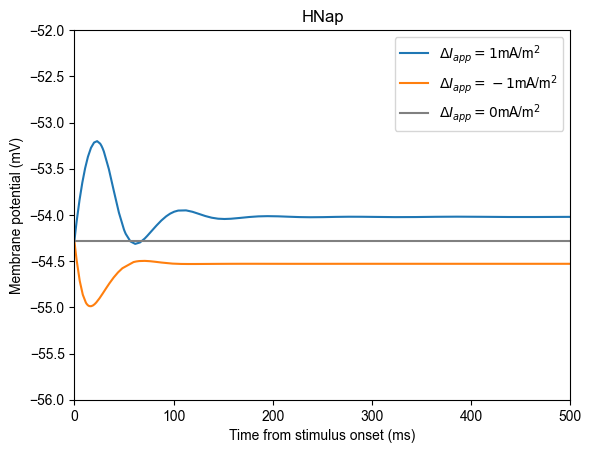

In [5]:
plt.plot(t1_corr, Vm1[t1_idxs], label=r'$\Delta I_{app} = 1 $mA/m$^2$')
plt.plot(t2_corr, Vm2[t2_idxs], label=r'$\Delta I_{app} = -1 $mA/m$^2$')
plt.axhline(Vm1[0], color='gray', linestyle='-', label=r'$\Delta I_{app} = 0 $mA/m$^2$')
plt.ylabel("Membrane potential (mV)")
plt.xlabel("Time from stimulus onset (ms)")
plt.legend()
plt.title("HNap")
plt.xlim([0, 500])
plt.ylim([-56, -52])

# Figure 2

In [4]:
# Define sonophore radius
a = 32e-9

# Define BLS models
lin_h_bls = NeuronalBilayerSonophore(a, lin_h_pn)
lin_ks_bls = NeuronalBilayerSonophore(a, lin_ks_pn)
quad_h_bls = NeuronalBilayerSonophore(a, quad_h_pn)
quad_ks_bls = NeuronalBilayerSonophore(a, quad_ks_pn)

In [7]:
# Define stimulus drive and time protocol
stim_dur = 200e-3
t_start = 200e-3
t_offset = 250e-3

th_pressure = 24.395e3
sub_drive = AcousticDrive(500e3, th_pressure - 5e2)
th_drive = AcousticDrive(500e3, th_pressure)
super_drive = AcousticDrive(500e3, th_pressure + 5e2)
pp = PulsedProtocol(tstim=stim_dur, toffset=t_offset, tstart=t_start)

# Run simulations and plot results
data1, _ = quad_h_bls.simulate(sub_drive, pp)
t1 = np.array(data1.t)
t1_idxs = (t1 >= t_start)
t1_corr = (t1[t1_idxs] - t_start) * 1e3
Vm1 = Qm_to_Vm_norm(data1.Qm)

data2, _ = quad_h_bls.simulate(th_drive, pp)
t2 = np.array(data2.t)
t2_idxs = (t2 >= t_start)
t2_corr = (t2[t2_idxs] - t_start) * 1e3
Vm2 = Qm_to_Vm_norm(data2.Qm)

data3, _ = quad_h_bls.simulate(super_drive, pp)
t3 = np.array(data3.t)
t3_idxs = (t3 >= t_start)
t3_corr = (t3[t3_idxs] - t_start) * 1e3
Vm3 = Qm_to_Vm_norm(data3.Qm)

 14/07/2025 00:12:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.89kPa, tstim = 200ms, toffset = 250ms, tstart = 200ms
 14/07/2025 00:12:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.39kPa, tstim = 200ms, toffset = 250ms, tstart = 200ms
 14/07/2025 00:12:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.89kPa, tstim = 200ms, toffset = 250ms, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Text(0.5, 1.0, 'Quadratic HNap')

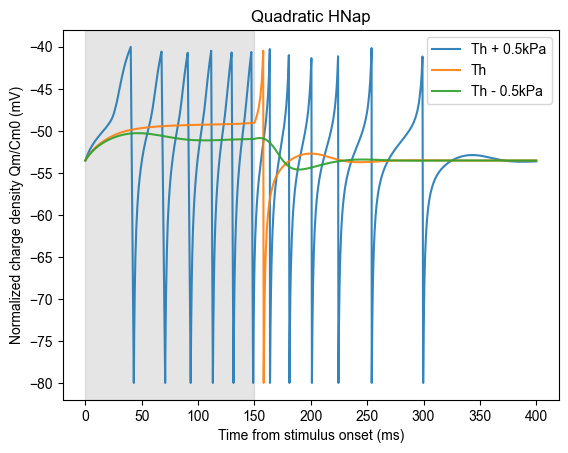

In [214]:
plt.figure()
plt.plot(t3_corr, Vm3[t3_idxs], label="Th + 0.5kPa", alpha=0.9)
plt.plot(t2_corr, Vm2[t2_idxs], label="Th", alpha=0.9)
plt.plot(t1_corr, Vm1[t1_idxs], label="Th - 0.5kPa", alpha=0.9)
plt.axvspan(0, stim_dur*1e3, color='grey', alpha=0.2)
plt.ylabel("Normalized charge density Qm/Cm0 (mV)")
plt.xlabel("Time from stimulus onset (ms)")
plt.legend()
plt.title("Quadratic HNap")

 13/07/2025 21:56:26: NeuronalBilayerSonophore(32.0 nm, LinearHNap): sonic simulation @ f = 500kHz, A = 23.77kPa, tstim = 150ms, toffset = 250ms, tstart = 200ms
 13/07/2025 21:56:26: NeuronalBilayerSonophore(32.0 nm, LinearHNap): sonic simulation @ f = 500kHz, A = 24.27kPa, tstim = 150ms, toffset = 250ms, tstart = 200ms
 13/07/2025 21:56:26: NeuronalBilayerSonophore(32.0 nm, LinearHNap): sonic simulation @ f = 500kHz, A = 24.77kPa, tstim = 150ms, toffset = 250ms, tstart = 200ms


Text(0.5, 1.0, 'Linear HNap')

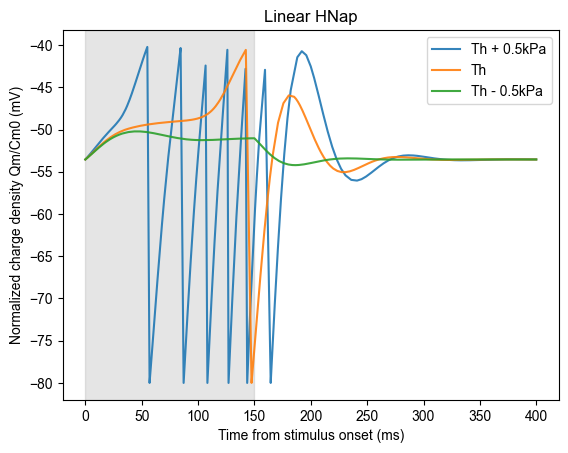

In [229]:
th_pressure = 24.27e3
sub_drive = AcousticDrive(500e3, th_pressure - 5e2)
th_drive = AcousticDrive(500e3, th_pressure)
super_drive = AcousticDrive(500e3, th_pressure + 5e2)
pp = PulsedProtocol(tstim=stim_dur, toffset=t_offset, tstart=t_start)

# Run simulations and plot results
data1, _ = lin_h_bls.simulate(sub_drive, pp)
t1 = np.array(data1.t)
t1_idxs = (t1 >= t_start)
t1_corr = (t1[t1_idxs] - t_start) * 1e3
Vm1 = Qm_to_Vm_norm(data1.Qm)

data2, _ = lin_h_bls.simulate(th_drive, pp)
t2 = np.array(data2.t)
t2_idxs = (t2 >= t_start)
t2_corr = (t2[t2_idxs] - t_start) * 1e3
Vm2 = Qm_to_Vm_norm(data2.Qm)

data3, _ = lin_h_bls.simulate(super_drive, pp)
t3 = np.array(data3.t)
t3_idxs = (t3 >= t_start)
t3_corr = (t3[t3_idxs] - t_start) * 1e3
Vm3 = Qm_to_Vm_norm(data3.Qm)

plt.figure()
plt.plot(t3_corr, Vm3[t3_idxs], label="Th + 0.5kPa", alpha=0.9)
plt.plot(t2_corr, Vm2[t2_idxs], label="Th", alpha=0.9)
plt.plot(t1_corr, Vm1[t1_idxs], label="Th - 0.5kPa", alpha=0.9)
plt.axvspan(0, stim_dur*1e3, color='grey', alpha=0.2)
plt.ylabel("Normalized charge density Qm/Cm0 (mV)")
plt.xlabel("Time from stimulus onset (ms)")
plt.legend()
plt.title("Linear HNap")

 13/07/2025 21:59:21: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 21.80kPa, tstim = 150ms, toffset = 250ms, tstart = 200ms
 13/07/2025 21:59:21: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 26.80kPa, tstim = 150ms, toffset = 250ms, tstart = 200ms
 13/07/2025 21:59:21: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 31.80kPa, tstim = 150ms, toffset = 250ms, tstart = 200ms


Text(0.5, 1.0, 'Quadratic KsNap')

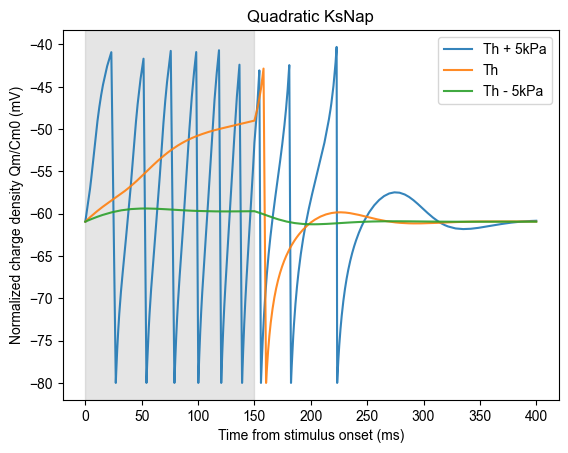

In [246]:
th_pressure = 26.8e3
sub_drive = AcousticDrive(500e3, th_pressure - 5e3)
th_drive = AcousticDrive(500e3, th_pressure)
super_drive = AcousticDrive(500e3, th_pressure + 5e3)
pp = PulsedProtocol(tstim=stim_dur, toffset=t_offset, tstart=t_start)

# Run simulations and plot results
data1, _ = quad_ks_bls.simulate(sub_drive, pp)
t1 = np.array(data1.t)
t1_idxs = (t1 >= t_start)
t1_corr = (t1[t1_idxs] - t_start) * 1e3
Vm1 = Qm_to_Vm_norm(data1.Qm)

data2, _ = quad_ks_bls.simulate(th_drive, pp)
t2 = np.array(data2.t)
t2_idxs = (t2 >= t_start)
t2_corr = (t2[t2_idxs] - t_start) * 1e3
Vm2 = Qm_to_Vm_norm(data2.Qm)

data3, _ = quad_ks_bls.simulate(super_drive, pp)
t3 = np.array(data3.t)
t3_idxs = (t3 >= t_start)
t3_corr = (t3[t3_idxs] - t_start) * 1e3
Vm3 = Qm_to_Vm_norm(data3.Qm)

plt.figure()
plt.plot(t3_corr, Vm3[t3_idxs], label="Th + 5kPa", alpha=0.9)
plt.plot(t2_corr, Vm2[t2_idxs], label="Th", alpha=0.9)
plt.plot(t1_corr, Vm1[t1_idxs], label="Th - 5kPa", alpha=0.9)
plt.axvspan(0, stim_dur*1e3, color='grey', alpha=0.2)
plt.ylabel("Normalized charge density Qm/Cm0 (mV)")
plt.xlabel("Time from stimulus onset (ms)")
plt.legend()
plt.title("Quadratic KsNap")

 13/07/2025 22:01:10: NeuronalBilayerSonophore(32.0 nm, LinearKsNap): sonic simulation @ f = 500kHz, A = 24.10kPa, tstim = 150ms, toffset = 250ms, tstart = 200ms
 13/07/2025 22:01:10: NeuronalBilayerSonophore(32.0 nm, LinearKsNap): sonic simulation @ f = 500kHz, A = 29.10kPa, tstim = 150ms, toffset = 250ms, tstart = 200ms
 13/07/2025 22:01:10: NeuronalBilayerSonophore(32.0 nm, LinearKsNap): sonic simulation @ f = 500kHz, A = 34.10kPa, tstim = 150ms, toffset = 250ms, tstart = 200ms


Text(0.5, 1.0, 'Linear KsNap')

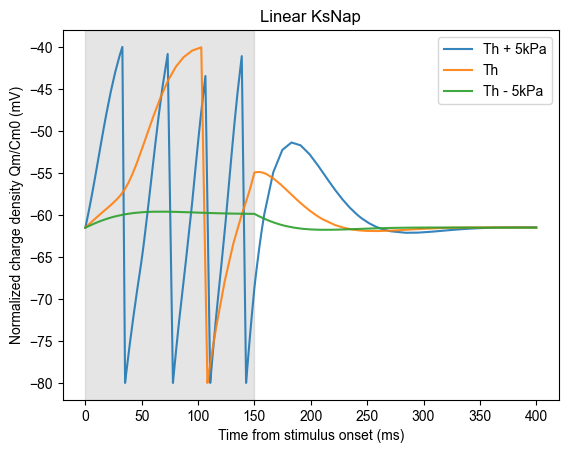

In [259]:
th_pressure = 29.1e3
sub_drive = AcousticDrive(500e3, th_pressure - 5e3)
th_drive = AcousticDrive(500e3, th_pressure)
super_drive = AcousticDrive(500e3, th_pressure + 5e3)
pp = PulsedProtocol(tstim=stim_dur, toffset=t_offset, tstart=t_start)

# Run simulations and plot results
data1, _ = lin_ks_bls.simulate(sub_drive, pp)
t1 = np.array(data1.t)
t1_idxs = (t1 >= t_start)
t1_corr = (t1[t1_idxs] - t_start) * 1e3
Vm1 = Qm_to_Vm_norm(data1.Qm)

data2, _ = lin_ks_bls.simulate(th_drive, pp)
t2 = np.array(data2.t)
t2_idxs = (t2 >= t_start)
t2_corr = (t2[t2_idxs] - t_start) * 1e3
Vm2 = Qm_to_Vm_norm(data2.Qm)

data3, _ = lin_ks_bls.simulate(super_drive, pp)
t3 = np.array(data3.t)
t3_idxs = (t3 >= t_start)
t3_corr = (t3[t3_idxs] - t_start) * 1e3
Vm3 = Qm_to_Vm_norm(data3.Qm)

plt.figure()
plt.plot(t3_corr, Vm3[t3_idxs], label="Th + 5kPa", alpha=0.9)
plt.plot(t2_corr, Vm2[t2_idxs], label="Th", alpha=0.9)
plt.plot(t1_corr, Vm1[t1_idxs], label="Th - 5kPa", alpha=0.9)
plt.axvspan(0, stim_dur*1e3, color='grey', alpha=0.2)
plt.ylabel("Normalized charge density Qm/Cm0 (mV)")
plt.xlabel("Time from stimulus onset (ms)")
plt.legend()
plt.title("Linear KsNap")

# Figure 3-6 data generation

In [31]:
# I attempted to use batches here but I got a ton of errors so I went with a manual loop. Takes ~5 min to run. 
# Run once for every cell type

prf_vals = [10, 100, 1000]                          # Hz
dc_vals = np.linspace(0, 1, 41)                     # %/100
amp_vals = np.logspace(1, np.log10(600), 41) * 1e3  # Pa

stim_dur = 200e-3
t_start = 200e-3
t_offset = 0

ff = 500e3
neuron = quad_ks_bls

In [32]:
latencies = np.empty((amp_vals.size, dc_vals.size, len(prf_vals)))
firingrates = np.empty((amp_vals.size, dc_vals.size, len(prf_vals)))

for prf_idx in range(len(prf_vals)):
    prf = prf_vals[prf_idx]
    for dc_idx in range(dc_vals.size):
        dc = dc_vals[dc_idx]
        for amp_idx in range(amp_vals.size):
            amp = amp_vals[amp_idx]
            drive = AcousticDrive(ff, amp)
            pp = PulsedProtocol(tstim=stim_dur, toffset=t_offset, tstart=t_start, PRF=prf, DC=dc)
            try:
                data, _ = neuron.simulate(drive, pp)
            except:
                print("Unstable")
            t = np.array(data.t)
            t_idxs = (t >= t_start)
            t_corr = (t[t_idxs] - t_start) * 1e3
            Vm = Qm_to_Vm_norm(data.Qm[t_idxs])
            lat, fr = detect_spikes(t_corr, Vm)
            latencies[amp_idx, dc_idx, prf_idx] = lat
            firingrates[amp_idx, dc_idx, prf_idx] = fr

 14/07/2025 02:04:14: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 10.00kPa, tstim = 200ms, PRF = 10.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 02:04:14: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 11.08kPa, tstim = 200ms, PRF = 10.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 02:04:14: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 12.27kPa, tstim = 200ms, PRF = 10.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 02:04:14: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 13.59kPa, tstim = 200ms, PRF = 10.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 02:04:14: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 15.06kPa, tstim = 200ms, PRF = 10.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 02:04:14: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 16.68kPa, tstim = 200m

 14/07/2025 02:04:15: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 15.06kPa, tstim = 200ms, PRF = 10.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 02:04:15: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 16.68kPa, tstim = 200ms, PRF = 10.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 02:04:15: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 18.48kPa, tstim = 200ms, PRF = 10.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 02:04:15: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 20.47kPa, tstim = 200ms, PRF = 10.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 02:04:15: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 22.68kPa, tstim = 200ms, PRF = 10.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 02:04:15: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 25.12kPa, tstim = 200m

 14/07/2025 02:04:16: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 22.68kPa, tstim = 200ms, PRF = 10.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 02:04:16: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 25.12kPa, tstim = 200ms, PRF = 10.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 02:04:16: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.83kPa, tstim = 200ms, PRF = 10.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 02:04:16: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 30.83kPa, tstim = 200ms, PRF = 10.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 02:04:16: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 34.15kPa, tstim = 200ms, PRF = 10.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 02:04:16: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 37.84kPa, tstim = 200m

 14/07/2025 02:04:16: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 34.15kPa, tstim = 200ms, PRF = 10.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 02:04:16: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 37.84kPa, tstim = 200ms, PRF = 10.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 02:04:16: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 41.91kPa, tstim = 200ms, PRF = 10.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 02:04:16: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.43kPa, tstim = 200ms, PRF = 10.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 02:04:16: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 51.44kPa, tstim = 200ms, PRF = 10.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 02:04:16: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 56.98kPa, tstim = 200m

 14/07/2025 02:04:17: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 51.44kPa, tstim = 200ms, PRF = 10.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 02:04:17: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 56.98kPa, tstim = 200ms, PRF = 10.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 02:04:17: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 63.12kPa, tstim = 200ms, PRF = 10.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 02:04:17: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 69.92kPa, tstim = 200ms, PRF = 10.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 02:04:17: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 77.46kPa, tstim = 200ms, PRF = 10.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 02:04:17: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 85.81kPa, tstim =

 14/07/2025 02:04:18: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 77.46kPa, tstim = 200ms, PRF = 10.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 02:04:18: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 85.81kPa, tstim = 200ms, PRF = 10.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 02:04:18: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 95.06kPa, tstim = 200ms, PRF = 10.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 02:04:18: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 105.30kPa, tstim = 200ms, PRF = 10.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 02:04:18: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 116.65kPa, tstim = 200ms, PRF = 10.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 02:04:18: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 129.22kPa, tsti

 14/07/2025 02:04:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 116.65kPa, tstim = 200ms, PRF = 10.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 02:04:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 129.22kPa, tstim = 200ms, PRF = 10.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 02:04:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 143.15kPa, tstim = 200ms, PRF = 10.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 02:04:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 158.58kPa, tstim = 200ms, PRF = 10.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 02:04:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 175.67kPa, tstim = 200ms, PRF = 10.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 02:04:20: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 194.61kPa, t

 14/07/2025 02:04:21: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 175.67kPa, tstim = 200ms, PRF = 10.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 02:04:21: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 194.61kPa, tstim = 200ms, PRF = 10.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 02:04:21: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 215.58kPa, tstim = 200ms, PRF = 10.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 02:04:21: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 238.82kPa, tstim = 200ms, PRF = 10.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 02:04:21: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 264.56kPa, tstim = 200ms, PRF = 10.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 02:04:21: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 293.07kPa, t

 14/07/2025 02:04:22: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 264.56kPa, tstim = 200ms, PRF = 10.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 02:04:22: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 293.07kPa, tstim = 200ms, PRF = 10.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 02:04:22: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 324.66kPa, tstim = 200ms, PRF = 10.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 02:04:22: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 359.65kPa, tstim = 200ms, PRF = 10.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 02:04:22: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 398.42kPa, tstim = 200ms, PRF = 10.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 02:04:22: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 441.36kPa, t

 14/07/2025 02:04:23: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 398.42kPa, tstim = 200ms, PRF = 10.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 02:04:23: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 441.36kPa, tstim = 200ms, PRF = 10.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 02:04:23: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 488.93kPa, tstim = 200ms, PRF = 10.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 02:04:24: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 541.62kPa, tstim = 200ms, PRF = 10.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 02:04:24: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 600.00kPa, tstim = 200ms, PRF = 10.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 02:04:24: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 10.00kPa, ts

 14/07/2025 02:04:25: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 600.00kPa, tstim = 200ms, PRF = 10.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 02:04:25: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 10.00kPa, tstim = 200ms, PRF = 10.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 02:04:25: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 11.08kPa, tstim = 200ms, PRF = 10.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 02:04:25: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 12.27kPa, tstim = 200ms, PRF = 10.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 02:04:25: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 13.59kPa, tstim = 200ms, PRF = 10.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 02:04:25: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 15.06kPa, tstim 

 14/07/2025 02:04:27: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 13.59kPa, tstim = 200ms, PRF = 10.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 02:04:27: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 15.06kPa, tstim = 200ms, PRF = 10.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 02:04:27: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 16.68kPa, tstim = 200ms, PRF = 10.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 02:04:27: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 18.48kPa, tstim = 200ms, PRF = 10.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 02:04:27: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 20.47kPa, tstim = 200ms, PRF = 10.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 02:04:27: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 22.68kPa, tstim =

 14/07/2025 02:04:28: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 20.47kPa, tstim = 200ms, PRF = 10.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 02:04:28: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 22.68kPa, tstim = 200ms, PRF = 10.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 02:04:28: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 25.12kPa, tstim = 200ms, PRF = 10.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 02:04:28: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.83kPa, tstim = 200ms, PRF = 10.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 02:04:28: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 30.83kPa, tstim = 200ms, PRF = 10.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 02:04:28: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 34.15kPa, tstim =

 14/07/2025 02:04:30: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 30.83kPa, tstim = 200ms, PRF = 10.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 02:04:30: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 34.15kPa, tstim = 200ms, PRF = 10.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 02:04:30: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 37.84kPa, tstim = 200ms, PRF = 10.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 02:04:30: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 41.91kPa, tstim = 200ms, PRF = 10.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 02:04:30: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.43kPa, tstim = 200ms, PRF = 10.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 02:04:30: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 51.44kPa, tstim =

 14/07/2025 02:04:32: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.43kPa, tstim = 200ms, PRF = 10.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 02:04:32: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 51.44kPa, tstim = 200ms, PRF = 10.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 02:04:32: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 56.98kPa, tstim = 200ms, PRF = 10.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 02:04:32: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 63.12kPa, tstim = 200ms, PRF = 10.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 02:04:32: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 69.92kPa, tstim = 200ms, PRF = 10.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 02:04:32: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 77.46kPa, tstim =

 14/07/2025 02:04:33: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 69.92kPa, tstim = 200ms, PRF = 10.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 02:04:33: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 77.46kPa, tstim = 200ms, PRF = 10.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 02:04:33: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 85.81kPa, tstim = 200ms, PRF = 10.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 02:04:33: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 95.06kPa, tstim = 200ms, PRF = 10.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 02:04:34: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 105.30kPa, tstim = 200ms, PRF = 10.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 02:04:34: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 116.65kPa, tstim

 14/07/2025 02:04:35: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 105.30kPa, tstim = 200ms, PRF = 10.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 02:04:35: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 116.65kPa, tstim = 200ms, PRF = 10.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 02:04:35: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 129.22kPa, tstim = 200ms, PRF = 10.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 02:04:36: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 143.15kPa, tstim = 200ms, PRF = 10.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 02:04:36: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 158.58kPa, tstim = 200ms, PRF = 10.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 02:04:36: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 175.67kPa, t

 14/07/2025 02:04:38: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 158.58kPa, tstim = 200ms, PRF = 10.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 02:04:38: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 175.67kPa, tstim = 200ms, PRF = 10.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 02:04:38: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 194.61kPa, tstim = 200ms, PRF = 10.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 02:04:38: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 215.58kPa, tstim = 200ms, PRF = 10.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 02:04:38: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 238.82kPa, tstim = 200ms, PRF = 10.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 02:04:38: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 264.56kPa, t

 14/07/2025 02:04:40: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 238.82kPa, tstim = 200ms, PRF = 10.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 02:04:40: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 264.56kPa, tstim = 200ms, PRF = 10.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 02:04:40: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 293.07kPa, tstim = 200ms, PRF = 10.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 02:04:40: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 324.66kPa, tstim = 200ms, PRF = 10.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 02:04:40: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 359.65kPa, tstim = 200ms, PRF = 10.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 02:04:40: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 398.42kPa, t

 14/07/2025 02:04:42: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 359.65kPa, tstim = 200ms, PRF = 10.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 02:04:42: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 398.42kPa, tstim = 200ms, PRF = 10.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 02:04:43: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 441.36kPa, tstim = 200ms, PRF = 10.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 02:04:43: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 488.93kPa, tstim = 200ms, PRF = 10.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 02:04:43: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 541.62kPa, tstim = 200ms, PRF = 10.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 02:04:43: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 600.00kPa, t

 14/07/2025 02:04:45: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 541.62kPa, tstim = 200ms, PRF = 10.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 02:04:45: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 600.00kPa, tstim = 200ms, PRF = 10.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 02:04:45: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 10.00kPa, tstim = 200ms, PRF = 10.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 02:04:45: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 11.08kPa, tstim = 200ms, PRF = 10.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 02:04:45: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 12.27kPa, tstim = 200ms, PRF = 10.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 02:04:45: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 13.59kPa, tstim

 14/07/2025 02:04:48: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 12.27kPa, tstim = 200ms, PRF = 10.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 02:04:48: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 13.59kPa, tstim = 200ms, PRF = 10.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 02:04:48: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 15.06kPa, tstim = 200ms, PRF = 10.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 02:04:48: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 16.68kPa, tstim = 200ms, PRF = 10.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 02:04:48: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 18.48kPa, tstim = 200ms, PRF = 10.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 02:04:48: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 20.47kPa, tstim =

 14/07/2025 02:04:50: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 18.48kPa, tstim = 200ms, PRF = 10.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 02:04:50: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 20.47kPa, tstim = 200ms, PRF = 10.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 02:04:50: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 22.68kPa, tstim = 200ms, PRF = 10.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 02:04:50: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 25.12kPa, tstim = 200ms, PRF = 10.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 02:04:50: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.83kPa, tstim = 200ms, PRF = 10.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 02:04:50: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 30.83kPa, tstim =

 14/07/2025 02:04:53: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.83kPa, tstim = 200ms, PRF = 10.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 02:04:53: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 30.83kPa, tstim = 200ms, PRF = 10.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 02:04:53: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 34.15kPa, tstim = 200ms, PRF = 10.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 02:04:53: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 37.84kPa, tstim = 200ms, PRF = 10.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 02:04:53: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 41.91kPa, tstim = 200ms, PRF = 10.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 02:04:53: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.43kPa, tstim =

 14/07/2025 02:04:55: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 41.91kPa, tstim = 200ms, PRF = 10.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 02:04:55: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.43kPa, tstim = 200ms, PRF = 10.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 02:04:56: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 51.44kPa, tstim = 200ms, PRF = 10.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 02:04:56: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 56.98kPa, tstim = 200ms, PRF = 10.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 02:04:56: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 63.12kPa, tstim = 200ms, PRF = 10.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 02:04:56: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 69.92kPa, tstim =

 14/07/2025 02:04:58: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 63.12kPa, tstim = 200ms, PRF = 10.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 02:04:58: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 69.92kPa, tstim = 200ms, PRF = 10.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 02:04:58: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 77.46kPa, tstim = 200ms, PRF = 10.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 02:04:58: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 85.81kPa, tstim = 200ms, PRF = 10.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 02:04:58: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 95.06kPa, tstim = 200ms, PRF = 10.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 02:04:58: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 105.30kPa, tstim 

 14/07/2025 02:05:01: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 95.06kPa, tstim = 200ms, PRF = 10.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 02:05:01: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 105.30kPa, tstim = 200ms, PRF = 10.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 02:05:01: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 116.65kPa, tstim = 200ms, PRF = 10.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 02:05:01: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 129.22kPa, tstim = 200ms, PRF = 10.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 02:05:01: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 143.15kPa, tstim = 200ms, PRF = 10.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 02:05:01: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 158.58kPa, ts

 14/07/2025 02:05:04: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 143.15kPa, tstim = 200ms, PRF = 10.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 02:05:04: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 158.58kPa, tstim = 200ms, PRF = 10.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 02:05:04: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 175.67kPa, tstim = 200ms, PRF = 10.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 02:05:04: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 194.61kPa, tstim = 200ms, PRF = 10.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 02:05:04: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 215.58kPa, tstim = 200ms, PRF = 10.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 02:05:05: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 238.82kPa, t

 14/07/2025 02:05:07: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 215.58kPa, tstim = 200ms, PRF = 10.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 02:05:07: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 238.82kPa, tstim = 200ms, PRF = 10.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 02:05:08: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 264.56kPa, tstim = 200ms, PRF = 10.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 02:05:08: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 293.07kPa, tstim = 200ms, PRF = 10.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 02:05:08: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 324.66kPa, tstim = 200ms, PRF = 10.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 02:05:08: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 359.65kPa, t

 14/07/2025 02:05:11: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 324.66kPa, tstim = 200ms, PRF = 10.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 02:05:11: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 359.65kPa, tstim = 200ms, PRF = 10.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 02:05:11: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 398.42kPa, tstim = 200ms, PRF = 10.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 02:05:11: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 441.36kPa, tstim = 200ms, PRF = 10.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 02:05:11: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 488.93kPa, tstim = 200ms, PRF = 10.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 02:05:12: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 541.62kPa, t

 14/07/2025 02:05:15: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 488.93kPa, tstim = 200ms, PRF = 10.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 02:05:15: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 541.62kPa, tstim = 200ms, PRF = 10.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 02:05:15: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 600.00kPa, tstim = 200ms, PRF = 10.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 02:05:15: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 10.00kPa, tstim = 200ms, PRF = 10.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 02:05:15: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 11.08kPa, tstim = 200ms, PRF = 10.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 02:05:15: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 12.27kPa, tsti

 14/07/2025 02:05:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 11.08kPa, tstim = 200ms, PRF = 10.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 02:05:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 12.27kPa, tstim = 200ms, PRF = 10.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 02:05:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 13.59kPa, tstim = 200ms, PRF = 10.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 02:05:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 15.06kPa, tstim = 200ms, PRF = 10.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 02:05:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 16.68kPa, tstim = 200ms, PRF = 10.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 02:05:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 18.48kPa, tstim =

 14/07/2025 02:05:22: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 16.68kPa, tstim = 200ms, PRF = 10.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 02:05:22: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 18.48kPa, tstim = 200ms, PRF = 10.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 02:05:22: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 20.47kPa, tstim = 200ms, PRF = 10.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 02:05:22: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 22.68kPa, tstim = 200ms, PRF = 10.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 02:05:22: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 25.12kPa, tstim = 200ms, PRF = 10.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 02:05:22: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.83kPa, tstim =

 14/07/2025 02:05:25: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 25.12kPa, tstim = 200ms, PRF = 10.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 02:05:25: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.83kPa, tstim = 200ms, PRF = 10.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 02:05:25: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 30.83kPa, tstim = 200ms, PRF = 10.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 02:05:25: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 34.15kPa, tstim = 200ms, PRF = 10.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 02:05:25: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 37.84kPa, tstim = 200ms, PRF = 10.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 02:05:25: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 41.91kPa, tstim =

 14/07/2025 02:05:29: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 37.84kPa, tstim = 200ms, PRF = 10.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 02:05:29: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 41.91kPa, tstim = 200ms, PRF = 10.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 02:05:29: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.43kPa, tstim = 200ms, PRF = 10.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 02:05:29: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 51.44kPa, tstim = 200ms, PRF = 10.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 02:05:29: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 56.98kPa, tstim = 200ms, PRF = 10.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 02:05:29: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 63.12kPa, tstim =

 14/07/2025 02:05:32: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 56.98kPa, tstim = 200ms, PRF = 10.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 02:05:32: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 63.12kPa, tstim = 200ms, PRF = 10.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 02:05:32: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 69.92kPa, tstim = 200ms, PRF = 10.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 02:05:32: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 77.46kPa, tstim = 200ms, PRF = 10.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 02:05:32: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 85.81kPa, tstim = 200ms, PRF = 10.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 02:05:33: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 95.06kPa, tstim =

 14/07/2025 02:05:36: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 85.81kPa, tstim = 200ms, PRF = 10.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 02:05:36: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 95.06kPa, tstim = 200ms, PRF = 10.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 02:05:36: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 105.30kPa, tstim = 200ms, PRF = 10.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 02:05:36: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 116.65kPa, tstim = 200ms, PRF = 10.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 02:05:36: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 129.22kPa, tstim = 200ms, PRF = 10.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 02:05:36: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 143.15kPa, tst

 14/07/2025 02:05:40: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 194.61kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 02:05:41: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 215.58kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 02:05:41: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 238.82kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 02:05:41: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 264.56kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 02:05:41: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 293.07kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 02:05:41: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 324.66kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 02:05:41: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A 

 14/07/2025 02:05:43: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 359.65kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 02:05:44: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 398.42kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 02:05:44: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 441.36kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 02:05:44: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 488.93kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 02:05:44: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 541.62kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 02:05:44: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 600.00kPa, t

 14/07/2025 02:05:45: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 541.62kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 02:05:45: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 600.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 02:05:45: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 10.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 02:05:45: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 11.08kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 02:05:45: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 12.27kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 02:05:45: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 13.59kPa, tstim

 14/07/2025 02:05:46: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 12.27kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 02:05:46: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 13.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 02:05:46: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 15.06kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 02:05:46: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 16.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 02:05:46: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 18.48kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 02:05:46: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 20.47kPa, tstim =

 14/07/2025 02:05:48: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 18.48kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 02:05:48: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 20.47kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 02:05:48: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 22.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 02:05:48: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 25.12kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 02:05:48: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 02:05:48: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 30.83kPa, ts

 14/07/2025 02:05:49: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 02:05:49: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 30.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 02:05:49: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 34.15kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 02:05:49: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 37.84kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 02:05:49: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 41.91kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 02:05:49: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.43kPa, ts

 14/07/2025 02:05:51: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 41.91kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 02:05:51: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.43kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 02:05:51: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 51.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 02:05:51: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 56.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 02:05:51: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 63.12kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 02:05:51: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 69.92kPa, ts

 14/07/2025 02:05:53: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 63.12kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 02:05:53: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 69.92kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 02:05:53: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 77.46kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 02:05:53: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 85.81kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 02:05:53: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 95.06kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 02:05:53: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 105.30kPa, t

 14/07/2025 02:05:55: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 95.06kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 02:05:55: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 105.30kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 02:05:55: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 116.65kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 02:05:55: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 129.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 02:05:55: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 143.15kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 02:05:55: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 158.58kP

 14/07/2025 02:05:57: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 143.15kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 02:05:57: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 158.58kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 02:05:57: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 175.67kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 02:05:57: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 194.61kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 02:05:57: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 215.58kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 02:05:57: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 238.82k

 14/07/2025 02:05:59: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 215.58kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 02:05:59: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 238.82kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 02:05:59: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 264.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 02:05:59: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 293.07kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 02:05:59: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 324.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 02:05:59: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 359.65k

 14/07/2025 02:06:01: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 324.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 02:06:01: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 359.65kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 02:06:01: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 398.42kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 02:06:01: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 441.36kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 02:06:02: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 488.93kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 02:06:02: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 541.62k

 14/07/2025 02:06:04: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 488.93kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 02:06:04: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 541.62kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 02:06:04: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 600.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 02:06:04: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 10.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 02:06:04: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 11.08kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 02:06:04: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 12.27kPa,

 14/07/2025 02:06:06: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 11.08kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 02:06:06: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 12.27kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 02:06:06: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 13.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 02:06:06: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 15.06kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 02:06:06: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 16.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 02:06:06: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 18.48kPa, ts

 14/07/2025 02:06:09: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 16.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 02:06:09: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 18.48kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 02:06:09: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 20.47kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 02:06:09: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 22.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 02:06:09: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 25.12kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 02:06:09: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.83kPa, ts

 14/07/2025 02:06:11: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 25.12kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 02:06:11: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 02:06:11: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 30.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 02:06:11: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 34.15kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 02:06:11: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 37.84kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 02:06:11: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 41.91kPa, ts

 14/07/2025 02:06:14: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 37.84kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 02:06:14: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 41.91kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 02:06:14: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.43kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 02:06:14: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 51.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 02:06:14: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 56.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 02:06:14: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 63.12kPa, ts

 14/07/2025 02:06:16: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 56.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 02:06:17: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 63.12kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 02:06:17: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 69.92kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 02:06:17: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 77.46kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 02:06:17: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 85.81kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 02:06:17: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 95.06kPa, ts

 14/07/2025 02:06:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 85.81kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 02:06:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 95.06kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 02:06:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 105.30kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 02:06:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 116.65kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 02:06:20: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 129.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 02:06:20: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 143.15kPa

 14/07/2025 02:06:22: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 129.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 02:06:22: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 143.15kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 02:06:22: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 158.58kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 02:06:23: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 175.67kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 02:06:23: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 194.61kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 02:06:23: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 215.58k

 14/07/2025 02:06:25: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 194.61kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 02:06:25: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 215.58kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 02:06:26: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 238.82kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 02:06:26: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 264.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 02:06:26: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 293.07kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 02:06:26: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 324.66k

 14/07/2025 02:06:29: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 293.07kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 02:06:29: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 324.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 02:06:29: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 359.65kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 02:06:29: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 398.42kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 02:06:29: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 441.36kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 02:06:29: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 488.93k

 14/07/2025 02:06:32: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 441.36kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 02:06:32: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 488.93kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 02:06:33: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 541.62kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 02:06:33: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 600.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 02:06:33: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 10.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 02:06:33: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 11.08kPa

 14/07/2025 02:06:36: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 10.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 02:06:36: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 11.08kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 02:06:36: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 12.27kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 02:06:36: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 13.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 02:06:36: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 15.06kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 02:06:36: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 16.68kPa, ts

 14/07/2025 02:06:39: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 15.06kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 02:06:40: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 16.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 02:06:40: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 18.48kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 02:06:40: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 20.47kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 02:06:40: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 22.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 02:06:40: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 25.12kPa, ts

 14/07/2025 02:06:43: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 22.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 02:06:43: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 25.12kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 02:06:43: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 02:06:43: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 30.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 02:06:43: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 34.15kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 02:06:43: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 37.84kPa, ts

 14/07/2025 02:06:46: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 34.15kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 02:06:46: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 37.84kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 02:06:46: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 41.91kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 02:06:46: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.43kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 02:06:46: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 51.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 02:06:46: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 56.98kPa, ts

 14/07/2025 02:06:50: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 51.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 02:06:50: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 56.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 02:06:50: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 63.12kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 02:06:50: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 69.92kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 02:06:50: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 77.46kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 02:06:50: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 85.81kPa, ts

 14/07/2025 02:06:53: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 77.46kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 02:06:53: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 85.81kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 02:06:53: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 95.06kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 02:06:53: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 105.30kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 02:06:54: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 116.65kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 02:06:54: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 129.22kPa,

 14/07/2025 02:06:57: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 116.65kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 02:06:57: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 129.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 02:06:57: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 143.15kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 02:06:58: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 158.58kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 02:06:58: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 175.67kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 02:06:58: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 194.61k

 14/07/2025 02:07:01: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 175.67kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 02:07:01: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 194.61kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 02:07:01: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 215.58kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 02:07:02: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 238.82kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 02:07:02: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 264.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 02:07:02: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 293.07k

 14/07/2025 02:07:05: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 264.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 02:07:05: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 293.07kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 02:07:06: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 324.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 02:07:06: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 359.65kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 02:07:06: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 398.42kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 02:07:06: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 441.36k

 14/07/2025 02:07:10: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 398.42kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 02:07:10: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 441.36kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 02:07:10: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 488.93kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 02:07:11: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 541.62kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 02:07:11: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 600.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 02:07:11: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 10.00kP

 14/07/2025 02:07:15: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 600.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 02:07:15: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 10.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 02:07:15: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 11.08kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 02:07:15: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 12.27kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 02:07:15: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 13.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 02:07:15: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 15.06kPa, t

 14/07/2025 02:07:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 13.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 02:07:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 15.06kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 02:07:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 16.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 02:07:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 18.48kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 02:07:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 20.47kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 02:07:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 22.68kPa, ts

 14/07/2025 02:07:23: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 20.47kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 02:07:23: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 22.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 02:07:23: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 25.12kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 02:07:23: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 02:07:23: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 30.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 02:07:23: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 34.15kPa, ts

 14/07/2025 02:07:28: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 30.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 02:07:28: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 34.15kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 02:07:28: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 37.84kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 02:07:28: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 41.91kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 02:07:28: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.43kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 02:07:28: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 51.44kPa, ts

 14/07/2025 02:07:32: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 56.98kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 02:07:32: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 63.12kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 02:07:32: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 69.92kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 02:07:32: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 77.46kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 02:07:32: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 85.81kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 02:07:32: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 95.06kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 02:07:32: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 105.

 14/07/2025 02:07:37: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 129.22kPa, tstim = 200ms, PRF = 1.00kHz, DC = 0.0%, tstart = 200ms
 14/07/2025 02:07:37: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 143.15kPa, tstim = 200ms, PRF = 1.00kHz, DC = 0.0%, tstart = 200ms
 14/07/2025 02:07:38: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 158.58kPa, tstim = 200ms, PRF = 1.00kHz, DC = 0.0%, tstart = 200ms
 14/07/2025 02:07:38: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 175.67kPa, tstim = 200ms, PRF = 1.00kHz, DC = 0.0%, tstart = 200ms
 14/07/2025 02:07:38: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 194.61kPa, tstim = 200ms, PRF = 1.00kHz, DC = 0.0%, tstart = 200ms
 14/07/2025 02:07:38: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 215.58kPa, tstim 

 14/07/2025 02:07:42: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 194.61kPa, tstim = 200ms, PRF = 1.00kHz, DC = 2.5%, tstart = 200ms
 14/07/2025 02:07:43: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 215.58kPa, tstim = 200ms, PRF = 1.00kHz, DC = 2.5%, tstart = 200ms
 14/07/2025 02:07:43: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 238.82kPa, tstim = 200ms, PRF = 1.00kHz, DC = 2.5%, tstart = 200ms
 14/07/2025 02:07:43: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 264.56kPa, tstim = 200ms, PRF = 1.00kHz, DC = 2.5%, tstart = 200ms
 14/07/2025 02:07:43: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 293.07kPa, tstim = 200ms, PRF = 1.00kHz, DC = 2.5%, tstart = 200ms
 14/07/2025 02:07:43: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 324.66kPa, tstim 

 14/07/2025 02:07:49: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 293.07kPa, tstim = 200ms, PRF = 1.00kHz, DC = 5.0%, tstart = 200ms
 14/07/2025 02:07:49: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 324.66kPa, tstim = 200ms, PRF = 1.00kHz, DC = 5.0%, tstart = 200ms
 14/07/2025 02:07:49: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 359.65kPa, tstim = 200ms, PRF = 1.00kHz, DC = 5.0%, tstart = 200ms
 14/07/2025 02:07:49: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 398.42kPa, tstim = 200ms, PRF = 1.00kHz, DC = 5.0%, tstart = 200ms
 14/07/2025 02:07:50: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 441.36kPa, tstim = 200ms, PRF = 1.00kHz, DC = 5.0%, tstart = 200ms
 14/07/2025 02:07:50: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 488.93kPa, tstim 

 14/07/2025 02:07:56: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 441.36kPa, tstim = 200ms, PRF = 1.00kHz, DC = 7.5%, tstart = 200ms
 14/07/2025 02:07:56: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 488.93kPa, tstim = 200ms, PRF = 1.00kHz, DC = 7.5%, tstart = 200ms
 14/07/2025 02:07:56: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 541.62kPa, tstim = 200ms, PRF = 1.00kHz, DC = 7.5%, tstart = 200ms
 14/07/2025 02:07:57: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 600.00kPa, tstim = 200ms, PRF = 1.00kHz, DC = 7.5%, tstart = 200ms
 14/07/2025 02:07:57: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 10.00kPa, tstim = 200ms, PRF = 1.00kHz, DC = 10.0%, tstart = 200ms
 14/07/2025 02:07:57: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 11.08kPa, tstim =

 14/07/2025 02:08:04: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 10.00kPa, tstim = 200ms, PRF = 1.00kHz, DC = 12.5%, tstart = 200ms
 14/07/2025 02:08:04: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 11.08kPa, tstim = 200ms, PRF = 1.00kHz, DC = 12.5%, tstart = 200ms
 14/07/2025 02:08:04: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 12.27kPa, tstim = 200ms, PRF = 1.00kHz, DC = 12.5%, tstart = 200ms
 14/07/2025 02:08:04: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 13.59kPa, tstim = 200ms, PRF = 1.00kHz, DC = 12.5%, tstart = 200ms
 14/07/2025 02:08:04: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 15.06kPa, tstim = 200ms, PRF = 1.00kHz, DC = 12.5%, tstart = 200ms
 14/07/2025 02:08:04: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 16.68kPa, tstim =

 14/07/2025 02:08:11: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 15.06kPa, tstim = 200ms, PRF = 1.00kHz, DC = 15.0%, tstart = 200ms
 14/07/2025 02:08:12: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 16.68kPa, tstim = 200ms, PRF = 1.00kHz, DC = 15.0%, tstart = 200ms
 14/07/2025 02:08:12: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 18.48kPa, tstim = 200ms, PRF = 1.00kHz, DC = 15.0%, tstart = 200ms
 14/07/2025 02:08:12: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 20.47kPa, tstim = 200ms, PRF = 1.00kHz, DC = 15.0%, tstart = 200ms
 14/07/2025 02:08:12: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 22.68kPa, tstim = 200ms, PRF = 1.00kHz, DC = 15.0%, tstart = 200ms
 14/07/2025 02:08:12: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 25.12kPa, tstim =

 14/07/2025 02:08:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 22.68kPa, tstim = 200ms, PRF = 1.00kHz, DC = 17.5%, tstart = 200ms
 14/07/2025 02:08:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 25.12kPa, tstim = 200ms, PRF = 1.00kHz, DC = 17.5%, tstart = 200ms
 14/07/2025 02:08:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.83kPa, tstim = 200ms, PRF = 1.00kHz, DC = 17.5%, tstart = 200ms
 14/07/2025 02:08:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 30.83kPa, tstim = 200ms, PRF = 1.00kHz, DC = 17.5%, tstart = 200ms
 14/07/2025 02:08:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 34.15kPa, tstim = 200ms, PRF = 1.00kHz, DC = 17.5%, tstart = 200ms
 14/07/2025 02:08:20: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 37.84kPa, tstim =

 14/07/2025 02:08:26: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 34.15kPa, tstim = 200ms, PRF = 1.00kHz, DC = 20.0%, tstart = 200ms
 14/07/2025 02:08:27: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 37.84kPa, tstim = 200ms, PRF = 1.00kHz, DC = 20.0%, tstart = 200ms
 14/07/2025 02:08:27: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 41.91kPa, tstim = 200ms, PRF = 1.00kHz, DC = 20.0%, tstart = 200ms
 14/07/2025 02:08:27: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.43kPa, tstim = 200ms, PRF = 1.00kHz, DC = 20.0%, tstart = 200ms
 14/07/2025 02:08:27: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 51.44kPa, tstim = 200ms, PRF = 1.00kHz, DC = 20.0%, tstart = 200ms
 14/07/2025 02:08:27: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 56.98kPa, tstim =

 14/07/2025 02:08:34: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 51.44kPa, tstim = 200ms, PRF = 1.00kHz, DC = 22.5%, tstart = 200ms
 14/07/2025 02:08:34: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 56.98kPa, tstim = 200ms, PRF = 1.00kHz, DC = 22.5%, tstart = 200ms
 14/07/2025 02:08:34: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 63.12kPa, tstim = 200ms, PRF = 1.00kHz, DC = 22.5%, tstart = 200ms
 14/07/2025 02:08:35: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 69.92kPa, tstim = 200ms, PRF = 1.00kHz, DC = 22.5%, tstart = 200ms
 14/07/2025 02:08:35: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 77.46kPa, tstim = 200ms, PRF = 1.00kHz, DC = 22.5%, tstart = 200ms
 14/07/2025 02:08:35: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 85.81kPa, tstim =

 14/07/2025 02:08:42: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 77.46kPa, tstim = 200ms, PRF = 1.00kHz, DC = 25.0%, tstart = 200ms
 14/07/2025 02:08:42: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 85.81kPa, tstim = 200ms, PRF = 1.00kHz, DC = 25.0%, tstart = 200ms
 14/07/2025 02:08:42: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 95.06kPa, tstim = 200ms, PRF = 1.00kHz, DC = 25.0%, tstart = 200ms
 14/07/2025 02:08:42: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 105.30kPa, tstim = 200ms, PRF = 1.00kHz, DC = 25.0%, tstart = 200ms
 14/07/2025 02:08:42: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 116.65kPa, tstim = 200ms, PRF = 1.00kHz, DC = 25.0%, tstart = 200ms
 14/07/2025 02:08:42: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 129.22kPa, tsti

 14/07/2025 02:08:49: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 116.65kPa, tstim = 200ms, PRF = 1.00kHz, DC = 27.5%, tstart = 200ms
 14/07/2025 02:08:49: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 129.22kPa, tstim = 200ms, PRF = 1.00kHz, DC = 27.5%, tstart = 200ms
 14/07/2025 02:08:50: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 143.15kPa, tstim = 200ms, PRF = 1.00kHz, DC = 27.5%, tstart = 200ms
 14/07/2025 02:08:50: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 158.58kPa, tstim = 200ms, PRF = 1.00kHz, DC = 27.5%, tstart = 200ms
 14/07/2025 02:08:50: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 175.67kPa, tstim = 200ms, PRF = 1.00kHz, DC = 27.5%, tstart = 200ms
 14/07/2025 02:08:50: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 194.61kPa, t

 14/07/2025 02:08:57: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 175.67kPa, tstim = 200ms, PRF = 1.00kHz, DC = 30.0%, tstart = 200ms
 14/07/2025 02:08:57: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 194.61kPa, tstim = 200ms, PRF = 1.00kHz, DC = 30.0%, tstart = 200ms
 14/07/2025 02:08:57: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 215.58kPa, tstim = 200ms, PRF = 1.00kHz, DC = 30.0%, tstart = 200ms
 14/07/2025 02:08:57: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 238.82kPa, tstim = 200ms, PRF = 1.00kHz, DC = 30.0%, tstart = 200ms
 14/07/2025 02:08:58: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 264.56kPa, tstim = 200ms, PRF = 1.00kHz, DC = 30.0%, tstart = 200ms
 14/07/2025 02:08:58: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 293.07kPa, t

 14/07/2025 02:09:05: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 264.56kPa, tstim = 200ms, PRF = 1.00kHz, DC = 32.5%, tstart = 200ms
 14/07/2025 02:09:05: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 293.07kPa, tstim = 200ms, PRF = 1.00kHz, DC = 32.5%, tstart = 200ms
 14/07/2025 02:09:05: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 324.66kPa, tstim = 200ms, PRF = 1.00kHz, DC = 32.5%, tstart = 200ms
 14/07/2025 02:09:05: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 359.65kPa, tstim = 200ms, PRF = 1.00kHz, DC = 32.5%, tstart = 200ms
 14/07/2025 02:09:05: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 398.42kPa, tstim = 200ms, PRF = 1.00kHz, DC = 32.5%, tstart = 200ms
 14/07/2025 02:09:06: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 441.36kPa, t

 14/07/2025 02:09:13: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 398.42kPa, tstim = 200ms, PRF = 1.00kHz, DC = 35.0%, tstart = 200ms
 14/07/2025 02:09:13: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 441.36kPa, tstim = 200ms, PRF = 1.00kHz, DC = 35.0%, tstart = 200ms
 14/07/2025 02:09:13: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 488.93kPa, tstim = 200ms, PRF = 1.00kHz, DC = 35.0%, tstart = 200ms
 14/07/2025 02:09:13: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 541.62kPa, tstim = 200ms, PRF = 1.00kHz, DC = 35.0%, tstart = 200ms
 14/07/2025 02:09:14: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 600.00kPa, tstim = 200ms, PRF = 1.00kHz, DC = 35.0%, tstart = 200ms
 14/07/2025 02:09:14: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 10.00kPa, ts

 14/07/2025 02:09:21: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 600.00kPa, tstim = 200ms, PRF = 1.00kHz, DC = 37.5%, tstart = 200ms
 14/07/2025 02:09:21: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 10.00kPa, tstim = 200ms, PRF = 1.00kHz, DC = 40.0%, tstart = 200ms
 14/07/2025 02:09:21: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 11.08kPa, tstim = 200ms, PRF = 1.00kHz, DC = 40.0%, tstart = 200ms
 14/07/2025 02:09:21: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 12.27kPa, tstim = 200ms, PRF = 1.00kHz, DC = 40.0%, tstart = 200ms
 14/07/2025 02:09:21: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 13.59kPa, tstim = 200ms, PRF = 1.00kHz, DC = 40.0%, tstart = 200ms
 14/07/2025 02:09:21: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 15.06kPa, tstim 

 14/07/2025 02:09:29: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 13.59kPa, tstim = 200ms, PRF = 1.00kHz, DC = 42.5%, tstart = 200ms
 14/07/2025 02:09:29: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 15.06kPa, tstim = 200ms, PRF = 1.00kHz, DC = 42.5%, tstart = 200ms
 14/07/2025 02:09:29: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 16.68kPa, tstim = 200ms, PRF = 1.00kHz, DC = 42.5%, tstart = 200ms
 14/07/2025 02:09:29: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 18.48kPa, tstim = 200ms, PRF = 1.00kHz, DC = 42.5%, tstart = 200ms
 14/07/2025 02:09:29: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 20.47kPa, tstim = 200ms, PRF = 1.00kHz, DC = 42.5%, tstart = 200ms
 14/07/2025 02:09:29: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 22.68kPa, tstim =

 14/07/2025 02:09:36: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 20.47kPa, tstim = 200ms, PRF = 1.00kHz, DC = 45.0%, tstart = 200ms
 14/07/2025 02:09:36: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 22.68kPa, tstim = 200ms, PRF = 1.00kHz, DC = 45.0%, tstart = 200ms
 14/07/2025 02:09:37: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 25.12kPa, tstim = 200ms, PRF = 1.00kHz, DC = 45.0%, tstart = 200ms
 14/07/2025 02:09:37: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.83kPa, tstim = 200ms, PRF = 1.00kHz, DC = 45.0%, tstart = 200ms
 14/07/2025 02:09:37: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 30.83kPa, tstim = 200ms, PRF = 1.00kHz, DC = 45.0%, tstart = 200ms
 14/07/2025 02:09:37: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 34.15kPa, tstim =

 14/07/2025 02:09:44: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 30.83kPa, tstim = 200ms, PRF = 1.00kHz, DC = 47.5%, tstart = 200ms
 14/07/2025 02:09:45: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 34.15kPa, tstim = 200ms, PRF = 1.00kHz, DC = 47.5%, tstart = 200ms
 14/07/2025 02:09:45: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 37.84kPa, tstim = 200ms, PRF = 1.00kHz, DC = 47.5%, tstart = 200ms
 14/07/2025 02:09:45: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 41.91kPa, tstim = 200ms, PRF = 1.00kHz, DC = 47.5%, tstart = 200ms
 14/07/2025 02:09:45: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.43kPa, tstim = 200ms, PRF = 1.00kHz, DC = 47.5%, tstart = 200ms
 14/07/2025 02:09:45: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 51.44kPa, tstim =

 14/07/2025 02:09:53: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.43kPa, tstim = 200ms, PRF = 1.00kHz, DC = 50.0%, tstart = 200ms
 14/07/2025 02:09:53: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 51.44kPa, tstim = 200ms, PRF = 1.00kHz, DC = 50.0%, tstart = 200ms
 14/07/2025 02:09:53: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 56.98kPa, tstim = 200ms, PRF = 1.00kHz, DC = 50.0%, tstart = 200ms
 14/07/2025 02:09:53: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 63.12kPa, tstim = 200ms, PRF = 1.00kHz, DC = 50.0%, tstart = 200ms
 14/07/2025 02:09:53: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 69.92kPa, tstim = 200ms, PRF = 1.00kHz, DC = 50.0%, tstart = 200ms
 14/07/2025 02:09:53: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 77.46kPa, tstim =

 14/07/2025 02:10:01: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 69.92kPa, tstim = 200ms, PRF = 1.00kHz, DC = 52.5%, tstart = 200ms
 14/07/2025 02:10:01: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 77.46kPa, tstim = 200ms, PRF = 1.00kHz, DC = 52.5%, tstart = 200ms
 14/07/2025 02:10:01: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 85.81kPa, tstim = 200ms, PRF = 1.00kHz, DC = 52.5%, tstart = 200ms
 14/07/2025 02:10:01: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 95.06kPa, tstim = 200ms, PRF = 1.00kHz, DC = 52.5%, tstart = 200ms
 14/07/2025 02:10:01: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 105.30kPa, tstim = 200ms, PRF = 1.00kHz, DC = 52.5%, tstart = 200ms
 14/07/2025 02:10:01: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 116.65kPa, tstim

 14/07/2025 02:10:09: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 105.30kPa, tstim = 200ms, PRF = 1.00kHz, DC = 55.0%, tstart = 200ms
 14/07/2025 02:10:09: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 116.65kPa, tstim = 200ms, PRF = 1.00kHz, DC = 55.0%, tstart = 200ms
 14/07/2025 02:10:09: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 129.22kPa, tstim = 200ms, PRF = 1.00kHz, DC = 55.0%, tstart = 200ms
 14/07/2025 02:10:09: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 143.15kPa, tstim = 200ms, PRF = 1.00kHz, DC = 55.0%, tstart = 200ms
 14/07/2025 02:10:10: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 158.58kPa, tstim = 200ms, PRF = 1.00kHz, DC = 55.0%, tstart = 200ms
 14/07/2025 02:10:10: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 175.67kPa, t

 14/07/2025 02:10:17: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 158.58kPa, tstim = 200ms, PRF = 1.00kHz, DC = 57.5%, tstart = 200ms
 14/07/2025 02:10:17: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 175.67kPa, tstim = 200ms, PRF = 1.00kHz, DC = 57.5%, tstart = 200ms
 14/07/2025 02:10:17: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 194.61kPa, tstim = 200ms, PRF = 1.00kHz, DC = 57.5%, tstart = 200ms
 14/07/2025 02:10:18: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 215.58kPa, tstim = 200ms, PRF = 1.00kHz, DC = 57.5%, tstart = 200ms
 14/07/2025 02:10:18: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 238.82kPa, tstim = 200ms, PRF = 1.00kHz, DC = 57.5%, tstart = 200ms
 14/07/2025 02:10:18: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 264.56kPa, t

 14/07/2025 02:10:25: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 238.82kPa, tstim = 200ms, PRF = 1.00kHz, DC = 60.0%, tstart = 200ms
 14/07/2025 02:10:26: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 264.56kPa, tstim = 200ms, PRF = 1.00kHz, DC = 60.0%, tstart = 200ms
 14/07/2025 02:10:26: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 293.07kPa, tstim = 200ms, PRF = 1.00kHz, DC = 60.0%, tstart = 200ms
 14/07/2025 02:10:26: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 324.66kPa, tstim = 200ms, PRF = 1.00kHz, DC = 60.0%, tstart = 200ms
 14/07/2025 02:10:26: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 359.65kPa, tstim = 200ms, PRF = 1.00kHz, DC = 60.0%, tstart = 200ms
 14/07/2025 02:10:27: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 398.42kPa, t

 14/07/2025 02:10:34: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 359.65kPa, tstim = 200ms, PRF = 1.00kHz, DC = 62.5%, tstart = 200ms
 14/07/2025 02:10:34: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 398.42kPa, tstim = 200ms, PRF = 1.00kHz, DC = 62.5%, tstart = 200ms
 14/07/2025 02:10:35: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 441.36kPa, tstim = 200ms, PRF = 1.00kHz, DC = 62.5%, tstart = 200ms
 14/07/2025 02:10:35: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 488.93kPa, tstim = 200ms, PRF = 1.00kHz, DC = 62.5%, tstart = 200ms
 14/07/2025 02:10:35: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 541.62kPa, tstim = 200ms, PRF = 1.00kHz, DC = 62.5%, tstart = 200ms
 14/07/2025 02:10:36: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 600.00kPa, t

 14/07/2025 02:10:43: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 541.62kPa, tstim = 200ms, PRF = 1.00kHz, DC = 65.0%, tstart = 200ms
 14/07/2025 02:10:44: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 600.00kPa, tstim = 200ms, PRF = 1.00kHz, DC = 65.0%, tstart = 200ms
 14/07/2025 02:10:44: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 10.00kPa, tstim = 200ms, PRF = 1.00kHz, DC = 67.5%, tstart = 200ms
 14/07/2025 02:10:44: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 11.08kPa, tstim = 200ms, PRF = 1.00kHz, DC = 67.5%, tstart = 200ms
 14/07/2025 02:10:44: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 12.27kPa, tstim = 200ms, PRF = 1.00kHz, DC = 67.5%, tstart = 200ms
 14/07/2025 02:10:44: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 13.59kPa, tstim

 14/07/2025 02:10:52: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 12.27kPa, tstim = 200ms, PRF = 1.00kHz, DC = 70.0%, tstart = 200ms
 14/07/2025 02:10:52: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 13.59kPa, tstim = 200ms, PRF = 1.00kHz, DC = 70.0%, tstart = 200ms
 14/07/2025 02:10:52: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 15.06kPa, tstim = 200ms, PRF = 1.00kHz, DC = 70.0%, tstart = 200ms
 14/07/2025 02:10:52: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 16.68kPa, tstim = 200ms, PRF = 1.00kHz, DC = 70.0%, tstart = 200ms
 14/07/2025 02:10:52: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 18.48kPa, tstim = 200ms, PRF = 1.00kHz, DC = 70.0%, tstart = 200ms
 14/07/2025 02:10:53: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 20.47kPa, tstim =

 14/07/2025 02:11:00: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 18.48kPa, tstim = 200ms, PRF = 1.00kHz, DC = 72.5%, tstart = 200ms
 14/07/2025 02:11:00: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 20.47kPa, tstim = 200ms, PRF = 1.00kHz, DC = 72.5%, tstart = 200ms
 14/07/2025 02:11:01: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 22.68kPa, tstim = 200ms, PRF = 1.00kHz, DC = 72.5%, tstart = 200ms
 14/07/2025 02:11:01: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 25.12kPa, tstim = 200ms, PRF = 1.00kHz, DC = 72.5%, tstart = 200ms
 14/07/2025 02:11:01: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.83kPa, tstim = 200ms, PRF = 1.00kHz, DC = 72.5%, tstart = 200ms
 14/07/2025 02:11:01: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 30.83kPa, tstim =

 14/07/2025 02:11:09: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.83kPa, tstim = 200ms, PRF = 1.00kHz, DC = 75.0%, tstart = 200ms
 14/07/2025 02:11:09: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 30.83kPa, tstim = 200ms, PRF = 1.00kHz, DC = 75.0%, tstart = 200ms
 14/07/2025 02:11:09: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 34.15kPa, tstim = 200ms, PRF = 1.00kHz, DC = 75.0%, tstart = 200ms
 14/07/2025 02:11:09: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 37.84kPa, tstim = 200ms, PRF = 1.00kHz, DC = 75.0%, tstart = 200ms
 14/07/2025 02:11:09: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 41.91kPa, tstim = 200ms, PRF = 1.00kHz, DC = 75.0%, tstart = 200ms
 14/07/2025 02:11:09: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.43kPa, tstim =

 14/07/2025 02:11:17: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 41.91kPa, tstim = 200ms, PRF = 1.00kHz, DC = 77.5%, tstart = 200ms
 14/07/2025 02:11:17: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.43kPa, tstim = 200ms, PRF = 1.00kHz, DC = 77.5%, tstart = 200ms
 14/07/2025 02:11:18: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 51.44kPa, tstim = 200ms, PRF = 1.00kHz, DC = 77.5%, tstart = 200ms
 14/07/2025 02:11:18: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 56.98kPa, tstim = 200ms, PRF = 1.00kHz, DC = 77.5%, tstart = 200ms
 14/07/2025 02:11:18: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 63.12kPa, tstim = 200ms, PRF = 1.00kHz, DC = 77.5%, tstart = 200ms
 14/07/2025 02:11:18: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 69.92kPa, tstim =

 14/07/2025 02:11:26: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 63.12kPa, tstim = 200ms, PRF = 1.00kHz, DC = 80.0%, tstart = 200ms
 14/07/2025 02:11:26: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 69.92kPa, tstim = 200ms, PRF = 1.00kHz, DC = 80.0%, tstart = 200ms
 14/07/2025 02:11:26: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 77.46kPa, tstim = 200ms, PRF = 1.00kHz, DC = 80.0%, tstart = 200ms
 14/07/2025 02:11:27: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 85.81kPa, tstim = 200ms, PRF = 1.00kHz, DC = 80.0%, tstart = 200ms
 14/07/2025 02:11:27: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 95.06kPa, tstim = 200ms, PRF = 1.00kHz, DC = 80.0%, tstart = 200ms
 14/07/2025 02:11:27: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 105.30kPa, tstim 

 14/07/2025 02:11:35: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 95.06kPa, tstim = 200ms, PRF = 1.00kHz, DC = 82.5%, tstart = 200ms
 14/07/2025 02:11:35: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 105.30kPa, tstim = 200ms, PRF = 1.00kHz, DC = 82.5%, tstart = 200ms
 14/07/2025 02:11:36: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 116.65kPa, tstim = 200ms, PRF = 1.00kHz, DC = 82.5%, tstart = 200ms
 14/07/2025 02:11:36: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 129.22kPa, tstim = 200ms, PRF = 1.00kHz, DC = 82.5%, tstart = 200ms
 14/07/2025 02:11:36: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 143.15kPa, tstim = 200ms, PRF = 1.00kHz, DC = 82.5%, tstart = 200ms
 14/07/2025 02:11:36: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 158.58kPa, ts

 14/07/2025 02:11:44: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 143.15kPa, tstim = 200ms, PRF = 1.00kHz, DC = 85.0%, tstart = 200ms
 14/07/2025 02:11:45: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 158.58kPa, tstim = 200ms, PRF = 1.00kHz, DC = 85.0%, tstart = 200ms
 14/07/2025 02:11:45: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 175.67kPa, tstim = 200ms, PRF = 1.00kHz, DC = 85.0%, tstart = 200ms
 14/07/2025 02:11:45: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 194.61kPa, tstim = 200ms, PRF = 1.00kHz, DC = 85.0%, tstart = 200ms
 14/07/2025 02:11:45: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 215.58kPa, tstim = 200ms, PRF = 1.00kHz, DC = 85.0%, tstart = 200ms
 14/07/2025 02:11:46: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 238.82kPa, t

 14/07/2025 02:11:54: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 215.58kPa, tstim = 200ms, PRF = 1.00kHz, DC = 87.5%, tstart = 200ms
 14/07/2025 02:11:54: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 238.82kPa, tstim = 200ms, PRF = 1.00kHz, DC = 87.5%, tstart = 200ms
 14/07/2025 02:11:54: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 264.56kPa, tstim = 200ms, PRF = 1.00kHz, DC = 87.5%, tstart = 200ms
 14/07/2025 02:11:54: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 293.07kPa, tstim = 200ms, PRF = 1.00kHz, DC = 87.5%, tstart = 200ms
 14/07/2025 02:11:55: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 324.66kPa, tstim = 200ms, PRF = 1.00kHz, DC = 87.5%, tstart = 200ms
 14/07/2025 02:11:55: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 359.65kPa, t

 14/07/2025 02:12:03: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 324.66kPa, tstim = 200ms, PRF = 1.00kHz, DC = 90.0%, tstart = 200ms
 14/07/2025 02:12:04: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 359.65kPa, tstim = 200ms, PRF = 1.00kHz, DC = 90.0%, tstart = 200ms
 14/07/2025 02:12:04: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 398.42kPa, tstim = 200ms, PRF = 1.00kHz, DC = 90.0%, tstart = 200ms
 14/07/2025 02:12:05: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 441.36kPa, tstim = 200ms, PRF = 1.00kHz, DC = 90.0%, tstart = 200ms
 14/07/2025 02:12:05: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 488.93kPa, tstim = 200ms, PRF = 1.00kHz, DC = 90.0%, tstart = 200ms
 14/07/2025 02:12:05: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 541.62kPa, t

 14/07/2025 02:12:14: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 488.93kPa, tstim = 200ms, PRF = 1.00kHz, DC = 92.5%, tstart = 200ms
 14/07/2025 02:12:14: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 541.62kPa, tstim = 200ms, PRF = 1.00kHz, DC = 92.5%, tstart = 200ms
 14/07/2025 02:12:15: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 600.00kPa, tstim = 200ms, PRF = 1.00kHz, DC = 92.5%, tstart = 200ms
 14/07/2025 02:12:15: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 10.00kPa, tstim = 200ms, PRF = 1.00kHz, DC = 95.0%, tstart = 200ms
 14/07/2025 02:12:15: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 11.08kPa, tstim = 200ms, PRF = 1.00kHz, DC = 95.0%, tstart = 200ms
 14/07/2025 02:12:15: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 12.27kPa, tsti

 14/07/2025 02:12:24: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 11.08kPa, tstim = 200ms, PRF = 1.00kHz, DC = 97.5%, tstart = 200ms
 14/07/2025 02:12:24: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 12.27kPa, tstim = 200ms, PRF = 1.00kHz, DC = 97.5%, tstart = 200ms
 14/07/2025 02:12:24: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 13.59kPa, tstim = 200ms, PRF = 1.00kHz, DC = 97.5%, tstart = 200ms
 14/07/2025 02:12:24: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 15.06kPa, tstim = 200ms, PRF = 1.00kHz, DC = 97.5%, tstart = 200ms
 14/07/2025 02:12:25: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 16.68kPa, tstim = 200ms, PRF = 1.00kHz, DC = 97.5%, tstart = 200ms
 14/07/2025 02:12:25: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 18.48kPa, tstim =

 14/07/2025 02:12:33: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 18.48kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 02:12:33: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 20.47kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 02:12:33: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 22.68kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 02:12:33: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 25.12kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 02:12:33: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.83kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 02:12:33: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 30.83kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 02:12:33: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 34.1

In [33]:
with open('data/quad_ksnap_behavior.pkl', 'wb') as f:
    pickle.dump([latencies, firingrates], f)

# Figure 3-6 plot generation

In [38]:
files = ["data/lin_hnap_behavior.pkl", 
        "data/lin_ksnap_behavior.pkl", 
        "data/quad_hnap_behavior.pkl", 
        "data/quad_ksnap_behavior.pkl"]

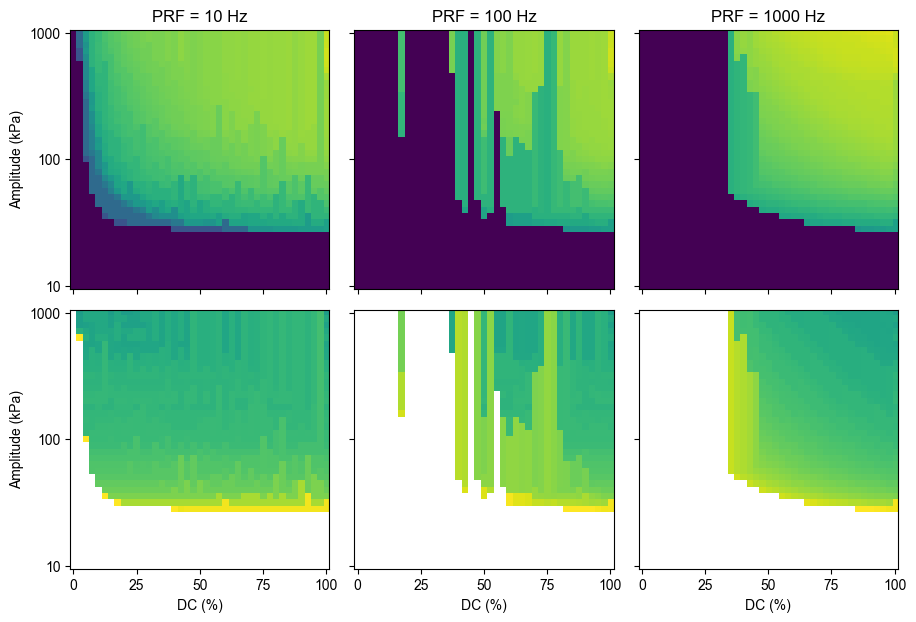

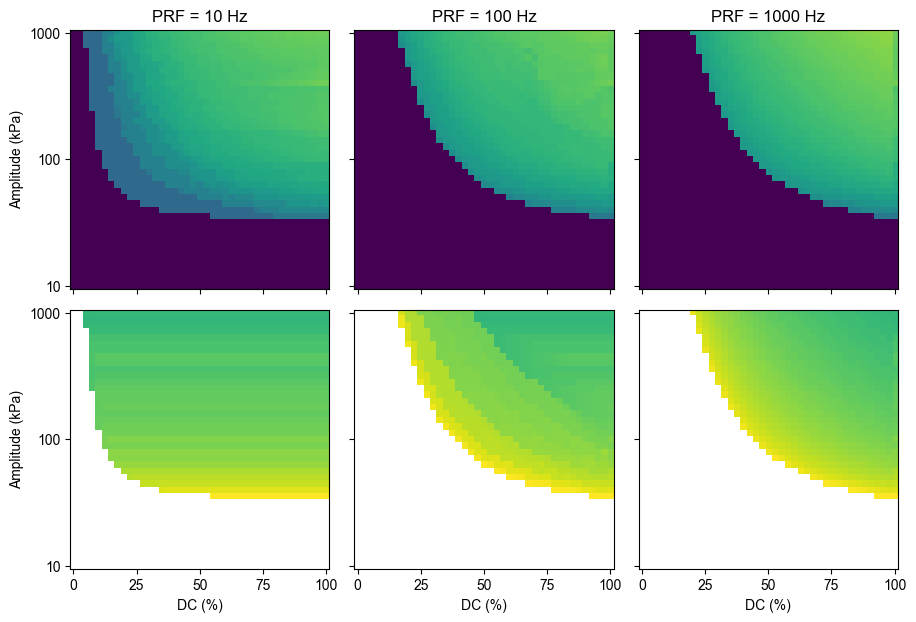

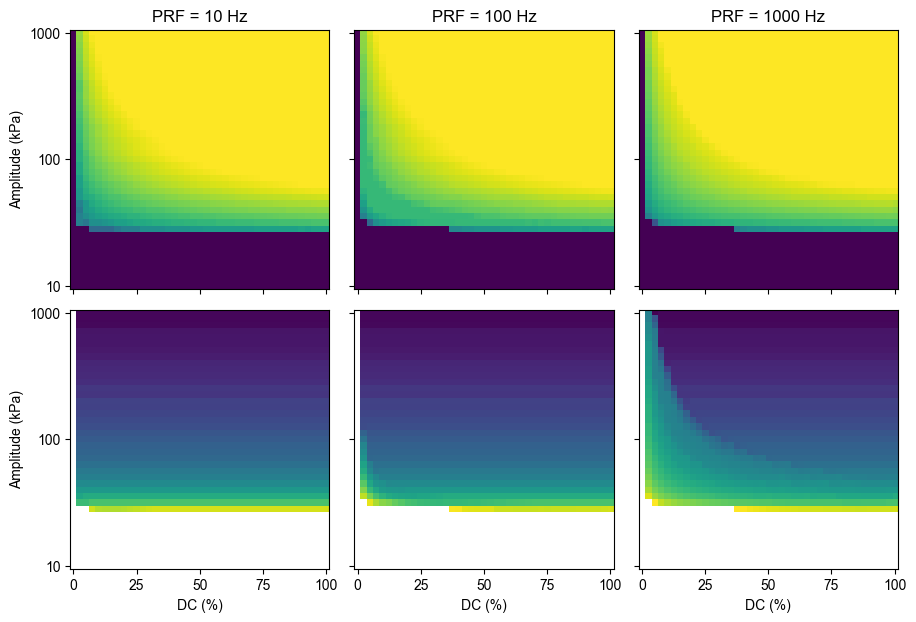

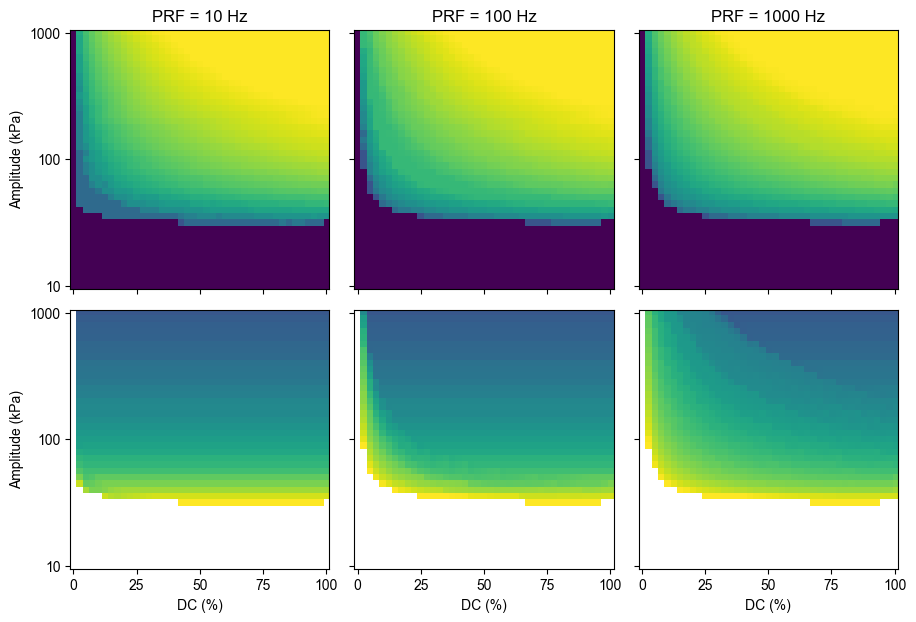

In [118]:
for idx in range(len(files)):
    with open(files[idx], 'rb') as f:
        dat = pickle.load(f)
    lat = dat[0]
    fr  = dat[1] + 1
    
    plt.figure(figsize=(11, 7))
    plt.subplots_adjust(wspace=0, hspace=0.08) 
    
    ax = plt.subplot(2, 3, 1)
    plt.imshow(fr[:, :, 0], origin='lower', norm=LogNorm(vmin=1, vmax=1000))
    plt.title("PRF = 10 Hz")
    ax.set_xticks([0, 10, 20, 30, 40])
    ax.set_xticklabels([])
    ax.set_yticks([0, 20, 40])
    ax.set_yticklabels([10, 100, 1000])
    plt.ylabel("Amplitude (kPa)")
    
    ax = plt.subplot(2, 3, 2)
    plt.imshow(fr[:, :, 1], origin='lower', norm=LogNorm(vmin=1, vmax=1000))
    plt.title("PRF = 100 Hz")
    ax.set_xticks([0, 10, 20, 30, 40])
    ax.set_xticklabels([])
    ax.set_yticks([0, 20, 40])
    ax.set_yticklabels([])
    
    ax = plt.subplot(2, 3, 3)
    plt.imshow(fr[:, :, 2], origin='lower', norm=LogNorm(vmin=1, vmax=1000))
    plt.title("PRF = 1000 Hz")
    ax.set_xticks([0, 10, 20, 30, 40])
    ax.set_xticklabels([])
    ax.set_yticks([0, 20, 40])
    ax.set_yticklabels([])
#     plt.colorbar()
    
    ax = plt.subplot(2, 3, 4)
    plt.imshow(lat[:, :, 0], origin='lower', norm=LogNorm(vmin=5e-2, vmax=5e1))
    plt.xlabel("DC (%)")
    plt.ylabel("Amplitude (kPa)")
    ax.set_xticks([0, 10, 20, 30, 40])
    ax.set_xticklabels([0, 25, 50, 75, 100])  # Fake log axis
    ax.set_yticks([0, 20, 40])
    ax.set_yticklabels([10, 100, 1000])
    
    ax = plt.subplot(2, 3, 5)
    plt.imshow(lat[:, :, 1], origin='lower', norm=LogNorm(vmin=5e-2, vmax=5e1))
    plt.xlabel("DC (%)")
    ax.set_xticks([0, 10, 20, 30, 40])
    ax.set_xticklabels([0, 25, 50, 75, 100])  # Fake log axis
    ax.set_yticks([0, 20, 40])
    ax.set_yticklabels([])
    
    ax = plt.subplot(2, 3, 6)
    plt.imshow(lat[:, :, 2], origin='lower', norm=LogNorm(vmin=5e-2, vmax=5e1))
    plt.xlabel("DC (%)")
    ax.set_xticks([0, 10, 20, 30, 40])
    ax.set_xticklabels([0, 25, 50, 75, 100])  # Fake log axis
    ax.set_yticks([0, 20, 40])
    ax.set_yticklabels([])
#     plt.colorbar()


# Figure 7

In [200]:
stim_dur = 200e-3
t_start = 200e-3
t_offset = 0
prf = 100
max_iters = 10
def find_threshold(pn, dc, radius, ff):
    quad_ks_bls = NeuronalBilayerSonophore(radius, pn)
    amp_lims = [10e3, 600e3]
    n_spikes = 0
    n_iters = 0
    while n_spikes != 1 and n_iters < max_iters:
        n_iters += 1
        amp_average = np.mean(amp_lims)
        drive = AcousticDrive(ff, amp_average)
        pp = PulsedProtocol(tstim=stim_dur, toffset=t_offset, tstart=t_start, PRF=prf, DC=dc)
        data, _ = quad_ks_bls.simulate(drive, pp)

        t = np.array(data.t)
        t_idxs = (t >= t_start)
        t_corr = (t[t_idxs] - t_start) * 1e3
        Vm = Qm_to_Vm_norm(data.Qm[t_idxs])
        spike_idxs = Vm <= -80                     # Check for instances of reset voltage
        n_spikes = np.sum(spike_idxs)              # Count spikes
        if n_spikes == 1:
            break
        elif n_spikes == 0:
            amp_lims[0] = amp_average
        else:
            amp_lims[1] = amp_average    
    return amp_average

In [201]:
dc_vals = np.linspace(0, 1, 41)                     # %/100
th_amps = np.empty((6, 41))
rad_vals = [16e-9, 32e-9, 64e-9]
output_idx = 0
for neuron in [quad_h_pn, quad_ks_pn]:
    for rad_idx in range(len(rad_vals)):
        rad = rad_vals[rad_idx]
        for dc_idx in range(dc_vals.size):
            dc = dc_vals[dc_idx]
            th_amps[output_idx, dc_idx] = find_threshold(neuron, dc, rad, 500e3)
        output_idx += 1

 14/07/2025 05:08:17: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:08:17: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 452.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:08:17: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 526.25kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:08:17: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 563.12kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:08:17: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 581.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:08:17: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 590.78kPa, tstim =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:17: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:08:17: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:08:17: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:08:17: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 65.31kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:08:17: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 56.09kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:08:17: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:18: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:08:18: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:08:18: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:08:18: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:08:18: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:08:18: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 42.27kPa, tstim = 200m

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:18: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:08:18: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:08:18: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:08:18: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:18: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:08:18: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:08:18: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:08:18: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 35.35kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:08:18: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:18: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:08:18: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:08:18: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:08:18: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:08:18: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:18: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:08:18: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 35.35kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:08:18: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 34.20kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:08:18: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 33.62kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:08:18: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:19: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:08:19: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:08:19: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:08:19: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:08:19: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:19: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:08:19: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:08:19: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 31.89kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:08:19: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:08:19: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:19: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:08:19: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:08:19: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:08:19: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:19: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:08:19: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:08:19: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:08:19: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:19: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:08:19: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:08:19: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:08:19: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:20: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:08:20: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:08:20: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 29.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:08:20: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 30.17kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:08:20: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:08:20: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:20: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:08:20: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:08:20: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:08:20: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:20: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:08:20: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:08:20: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 29.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:08:20: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:20: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:08:20: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:08:20: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:08:20: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:08:20: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:20: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:08:20: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:08:20: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 29.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:08:21: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 29.01kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:08:21: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:21: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:08:21: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:21: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:08:21: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:08:21: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:08:21: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:08:21: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:08:21: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 29.59kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:21: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 29.01kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:08:21: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:08:21: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:08:21: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:21: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:08:21: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:08:21: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:08:21: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:21: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:08:22: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:22: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:08:22: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:08:22: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:08:22: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:08:22: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:08:22: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.86kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:22: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:08:22: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:08:22: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:08:22: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:08:22: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:22: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:08:22: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:08:22: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:08:22: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.86kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:08:22: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:22: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:08:22: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:08:22: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:08:22: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:08:22: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:22: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:08:23: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:08:23: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:08:23: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.86kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:08:23: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:23: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:08:23: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:08:23: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:08:23: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:23: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:08:23: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:08:23: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:08:23: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:08:23: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.86kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:08:23: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:23: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:08:23: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:08:23: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:08:23: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:08:23: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:23: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:08:23: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:08:23: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:08:24: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:24: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:08:24: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:08:24: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:08:24: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:24: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:08:24: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:08:24: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:08:24: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:08:24: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:24: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:08:24: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:08:24: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:08:24: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:24: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:08:24: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:08:24: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:08:24: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:08:24: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:25: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:08:25: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:08:25: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:08:25: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:25: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:08:25: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:08:25: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:08:25: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:08:25: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:25: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:08:25: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:08:25: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:08:25: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:25: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:08:25: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:08:25: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:08:25: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:08:25: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.71kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:08:25: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:25: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:08:26: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:08:26: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:08:26: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:26: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:08:26: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:08:26: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:08:26: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:08:26: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.71kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:08:26: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:26: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:08:26: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:08:26: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:08:26: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:26: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:08:26: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:08:26: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:08:26: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:08:26: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.71kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:08:26: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:26: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:08:27: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:08:27: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:08:27: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:08:27: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:08:27: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:08:27: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:27: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:08:27: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.71kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:08:27: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:27: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:08:27: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:08:27: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:08:27: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:27: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:08:27: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:08:27: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:08:27: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:08:27: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.71kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:08:27: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:28: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:08:28: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:08:28: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:28: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:08:28: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:08:28: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:08:28: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:08:28: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:08:28: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.71kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:28: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:08:28: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:08:28: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:08:28: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:28: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:08:28: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:08:28: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:08:28: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:08:28: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.71kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:08:28: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:29: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:08:29: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:08:29: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:08:29: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:08:29: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:08:29: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:08:29: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:29: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:08:29: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.71kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:08:29: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:29: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:08:29: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:08:29: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:08:29: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:08:29: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:08:29: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:08:29: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:08:30: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:30: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:08:30: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:08:30: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:08:30: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:08:30: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:08:30: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:30: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:08:30: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:08:30: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:30: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:08:30: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:08:30: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:30: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:08:31: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:08:31: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:08:31: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:08:31: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:08:31: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:31: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:08:31: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:08:31: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:08:31: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:08:31: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:08:31: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:08:31: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:08:31: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:31: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:08:32: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:08:32: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:08:32: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:08:32: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:08:32: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:32: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:08:32: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:08:32: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.86kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:08:32: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:32: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:08:32: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:08:32: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:32: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:08:32: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:08:32: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:08:32: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:08:32: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:08:32: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.86kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:33: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:08:33: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:08:33: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:08:33: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:08:33: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:08:33: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:08:33: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:08:33: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:33: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.86kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:08:33: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:08:33: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:08:33: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:08:33: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:08:33: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:08:33: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:34: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:08:34: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:08:34: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:08:34: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:08:34: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:08:34: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:08:34: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:34: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 29.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:08:34: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 29.01kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:08:34: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:34: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:08:35: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:08:35: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:08:35: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:08:35: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:08:35: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:08:35: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:08:35: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 29.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:35: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:08:35: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:08:35: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:08:35: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:08:35: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:08:35: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:08:35: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:08:35: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:08:35: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 31.89kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:35: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 31.32kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:08:35: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:36: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:08:36: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:08:36: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:08:36: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:08:36: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:08:36: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:08:36: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 35.35kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:08:36: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 34.20kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:36: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:08:36: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:08:36: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:08:36: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:08:37: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:37: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 37.66kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:08:37: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 42.27kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:08:37: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 44.57kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:08:37: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 45.72kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:08:37: NeuronalBilayerSonophore(16.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 45.15kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:08:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:08:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 597.70kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:08:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 598.85kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:08:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 599.42kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:08:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:08:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:08:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:08:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:08:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:08:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:08:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 29.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:08:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200m

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:08:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:08:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:08:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:08:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:08:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:08:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:08:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.86kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:08:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200m

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:08:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:08:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:08:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:08:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:08:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:08:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.71kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:08:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:08:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:08:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:08:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:08:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:08:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:08:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:08:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.71kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:08:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:08:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:08:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:08:40: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:08:40: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:08:40: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.71kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:40: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:40: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:08:40: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:08:40: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:40: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:08:40: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:08:40: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:08:40: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:40: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:08:40: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:08:40: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:08:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:08:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:08:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:08:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:08:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:08:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:08:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:08:42: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:42: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:08:42: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:08:42: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:08:42: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:08:42: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:08:42: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:42: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:08:42: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:42: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:08:42: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:42: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:08:42: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:08:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:08:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:08:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:08:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:08:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:08:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:08:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:08:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:08:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:08:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:08:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:08:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:08:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:08:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:08:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:08:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:08:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:08:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:08:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:08:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:08:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:08:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:08:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:08:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:08:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:08:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:08:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:08:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:08:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:08:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:08:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:08:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:08:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:47: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:08:47: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:47: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:08:47: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:47: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:08:47: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:08:47: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:08:47: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:08:47: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:47: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:08:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:08:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:08:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:08:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:08:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:08:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 25.56kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:49: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:49: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:08:49: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:49: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:08:49: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:08:49: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:08:49: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:08:49: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:49: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:08:49: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:50: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:50: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:08:50: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:08:50: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:50: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:08:50: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:08:50: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:08:51: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:08:51: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:08:51: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:51: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:51: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:08:51: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:52: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:08:52: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:08:52: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:08:52: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:08:52: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:08:52: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:52: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:52: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:08:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:08:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:08:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:08:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:08:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:08:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:08:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:08:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:08:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:08:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:08:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:08:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:08:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:08:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:08:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:08:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:08:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:08:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:08:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:08:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:08:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:08:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:08:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:08:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:08:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:08:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:08:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:08:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:08:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:08:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:08:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:08:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:08:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:08:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:08:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:08:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:08:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:08:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:00: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:00: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:09:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:09:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:09:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:09:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:09:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:09:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:02: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:09:02: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:02: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:09:02: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:09:02: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:09:02: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:02: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:09:02: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:09:02: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:03: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:03: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:09:03: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:03: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:09:03: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:04: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:09:04: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:09:04: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:09:04: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:09:04: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:09:04: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:09:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:09:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:09:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:09:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:09:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:09:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:09:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:09:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:09:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:09:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:09:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:09:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:09:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:09:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:09:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:09:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:09:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:09:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:09:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:09: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:09: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:09:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:09:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:09:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:09:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:09:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:09:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:09:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:09:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:09:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:09:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:09:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:09:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:09:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:09:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:09:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:09:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:09:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:09:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:09:14: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:14: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:09:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:09:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:09:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:09:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:09:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:09:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:09:17: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:09:17: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:09:17: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:17: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:09:17: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:09:17: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:09:17: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:09:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:09:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:09:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:09:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:09:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:09:19: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:09:19: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:09:19: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:09:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:09:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:09:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:09:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:09:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:09:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:09:21: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:09:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:09:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:09:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:09:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:09:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:09:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:23: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:09:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:09:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:09:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:09:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:09:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:09:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:09:25: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:25: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:26: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:09:26: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:09:26: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:09:26: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:09:26: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:09:26: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:09:26: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, t

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:09:26: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:09:26: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 452.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:09:26: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 526.25kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:09:26: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 563.12kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:09:26: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 581.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:09:26: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 590.78kPa, tstim =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:09:26: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:09:26: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:09:27: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:09:27: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:09:27: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:09:27: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200m

 14/07/2025 05:09:31: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:09:31: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:09:31: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:09:31: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:09:31: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:09:32: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim 

 14/07/2025 05:09:39: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:09:40: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:09:40: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:09:40: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:09:40: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:09:40: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim =

 14/07/2025 05:09:50: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:09:50: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:09:50: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:09:51: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:09:51: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:09:52: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim 

 14/07/2025 05:10:05: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:10:06: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:10:06: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:10:07: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:10:07: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:10:07: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim =

 14/07/2025 05:10:23: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:10:23: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:10:23: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:10:23: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:10:23: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:10:25: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim 

 14/07/2025 05:10:43: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:10:45: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:10:45: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:10:45: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:10:46: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:10:46: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim =

 14/07/2025 05:11:07: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:11:07: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:11:07: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:11:07: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:11:07: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:11:10: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim 

 14/07/2025 05:11:34: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:11:36: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:11:37: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:11:37: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:11:37: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:11:37: NeuronalBilayerSonophore(64.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim =

 14/07/2025 05:11:57: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 597.70kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:11:57: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 598.85kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:11:57: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 599.42kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:11:57: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:11:57: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 452.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:11:58: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 526.25kPa, t

 14/07/2025 05:11:59: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:11:59: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:11:59: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 65.31kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:11:59: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 56.09kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:11:59: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:11:59: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 157.50kPa, 

 14/07/2025 05:12:00: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:12:00: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:12:00: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 65.31kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:12:00: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 56.09kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:12:00: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 51.48kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:12:01: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 305.00kPa, t

 14/07/2025 05:12:02: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:12:02: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:12:02: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 65.31kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:12:02: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 56.09kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:12:02: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 51.48kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:12:02: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 49.18kPa, ts

 14/07/2025 05:12:04: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:12:04: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 65.31kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:12:04: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 56.09kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:12:04: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 51.48kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:12:04: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 53.79kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:12:04: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 305.00kPa, t

 14/07/2025 05:12:05: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:12:05: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:12:05: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:12:05: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:12:05: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 65.31kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:12:05: NeuronalBilayerSonophore(16.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 74.53kPa, 

 14/07/2025 05:12:06: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:12:06: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:12:07: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:12:07: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:12:07: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:12:07: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim

 14/07/2025 05:12:08: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 31.89kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:12:08: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 32.47kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:12:08: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:12:08: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:12:08: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:12:08: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.88kPa, 

 14/07/2025 05:12:10: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:12:10: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:12:10: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:12:10: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:12:10: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 29.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:12:10: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 30.17kPa, ts

 14/07/2025 05:12:12: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:12:12: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:12:12: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:12:12: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:12:12: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:12:12: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 33.05kPa, t

 14/07/2025 05:12:14: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:12:14: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:12:14: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:12:14: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:12:14: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:12:14: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 157.50kPa,

 14/07/2025 05:12:16: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:12:16: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:12:17: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:12:17: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:12:17: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:12:17: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 23.83kPa, t

 14/07/2025 05:12:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:12:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:12:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:12:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.86kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:12:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:12:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 157.50kPa, 

 14/07/2025 05:12:21: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:12:22: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:12:22: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:12:22: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:12:22: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:12:22: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 23.83kPa, t

 14/07/2025 05:12:24: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 597.70kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:12:24: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 598.85kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:12:24: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 599.42kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:12:24: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:12:24: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:12:24: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 83.75kPa, ts

 14/07/2025 05:12:26: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:12:26: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:12:26: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:12:26: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:12:26: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 29.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:12:26: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 30.17kPa, ts

 14/07/2025 05:12:29: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 30.17kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:12:29: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:12:29: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:12:29: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:12:29: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:12:29: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 28.44kPa, 

 14/07/2025 05:12:33: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:12:33: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:12:33: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:12:33: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:12:33: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 29.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:12:33: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 29.01kPa, ts

 14/07/2025 05:12:37: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 29.01kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:12:37: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:12:38: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:12:38: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:12:38: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:12:38: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 28.44kPa, 

 14/07/2025 05:12:43: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:12:43: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:12:43: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:12:43: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:12:43: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:12:43: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.86kPa, ts

 14/07/2025 05:12:48: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 26.71kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:12:48: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:12:49: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:12:49: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:12:50: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:12:50: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 28.44kPa, 

 14/07/2025 05:12:56: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:12:56: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:12:56: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:12:56: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:12:56: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:12:56: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 26.71kPa, ts

 14/07/2025 05:13:02: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:13:02: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:13:03: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:13:04: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:13:04: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:13:04: NeuronalBilayerSonophore(64.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 28.44kPa, 

Text(0, 0.5, 'Amplitude (kPa)')

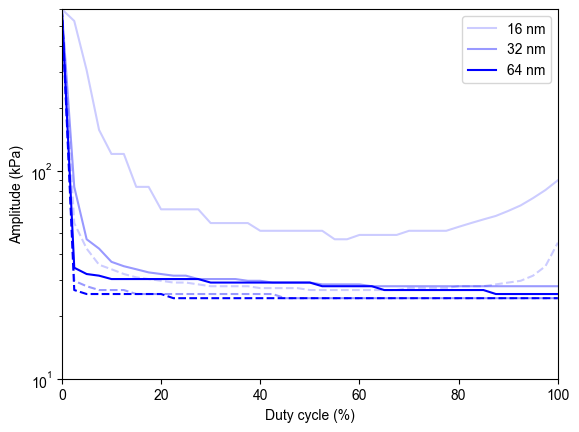

In [202]:
plt.figure()
plt.plot(dc_vals * 100, th_amps[0, :] / 1e3, color='blue', alpha=0.2, linestyle='--')
plt.plot(dc_vals * 100, th_amps[1, :] / 1e3, color='blue', alpha=0.4, linestyle='--')
plt.plot(dc_vals * 100, th_amps[2, :] / 1e3, color='blue', alpha=1.0, linestyle='--')
plt.plot(dc_vals * 100, th_amps[3, :] / 1e3, color='blue', alpha=0.2, label="16 nm")
plt.plot(dc_vals * 100, th_amps[4, :] / 1e3, color='blue', alpha=0.4, label="32 nm")
plt.plot(dc_vals * 100, th_amps[5, :] / 1e3, color='blue', alpha=1.0, label="64 nm")
plt.xlim(0, 100)
plt.ylim(10, 600)
plt.legend()
plt.yticks(np.concatenate((np.linspace(10, 100, 10), np.linspace(200, 600, 5))))
plt.yscale('log')
plt.xlabel("Duty cycle (%)")
plt.ylabel("Amplitude (kPa)")

In [203]:
dc_vals = np.linspace(0, 1, 41)                     # %/100
th_amps_ff = np.empty((6, 41))
ff_vals = [20e3, 500e3, 4e6]
output_idx = 0
for neuron in [quad_h_pn, quad_ks_pn]:
    for ff_idx in range(len(ff_vals)):
        ff = ff_vals[ff_idx]
        for dc_idx in range(dc_vals.size):
            dc = dc_vals[dc_idx]
            th_amps_ff[output_idx, dc_idx] = find_threshold(neuron, dc, 32e-9, ff)
        output_idx += 1

 14/07/2025 05:14:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:14:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 452.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:14:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 526.25kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:14:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 563.12kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:14:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 581.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:14:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 590.78kPa, tstim = 200ms

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:14:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:14:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:14:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:14:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:14:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:14:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 29.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:14:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 29.01kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:14:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:14:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:14:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:14:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:14:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:14:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:14:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 26.71kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:14:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:14:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:14:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:14:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:14:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:14:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:14:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:14:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 26.71kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:14:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:14:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:14:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:14:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:14:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:14:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:14:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:14:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:14:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:14:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:14:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:14:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:14:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:14:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:14:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:14:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:14:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:14:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:14:09: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:14:09: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:09: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:14:09: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:14:09: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:09: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:14:09: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:09: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:14:09: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:14:09: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:14:09: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:14:09: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:14:09: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 24.98kPa, tstim = 200ms,

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:09: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:14:09: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:14:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:14:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:14:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:14:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:14:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:14:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:14:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:14:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:14:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:14:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:14:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:14:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:14:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:14:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:14:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:14:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:14:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:14:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:14:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 24.98kPa, tstim = 200ms,

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:14:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:14:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:14:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:14:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:14:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:14:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:14:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 24.98kPa, tstim = 200ms,

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:14:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:14:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:14:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:14:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:14:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:14:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:14:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 24.98kPa, tstim = 200ms,

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:14:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:14: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:14:14: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:14: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:14: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:14:14: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:14:14: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:14:14: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:14:14: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:14:14: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 24.40kPa, tstim = 200ms,

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:14:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:14:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:14:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:14:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:14:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:14:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:14:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:14:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:14:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:14:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:14:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:14:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:14:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:17: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:17: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:17: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:14:17: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:14:17: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:14:17: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:14:17: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:14:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:14:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:14:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:14:19: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:14:19: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:14:19: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:14:19: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:14:19: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 24.40kPa, tstim = 200ms,

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:19: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:19: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:19: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:14:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:14:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:14:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:14:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:14:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:14:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:21: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:14:21: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:21: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:14:21: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:14:21: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:14:21: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 21.52kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:14:21: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:14:21: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.25kPa, tstim = 200ms,

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:21: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:14:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:14:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:14:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:14:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 21.52kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:14:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:14:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.25kPa, tstim = 200ms,

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:23: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:23: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:14:23: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:23: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:14:23: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:14:23: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:14:23: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 21.52kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:23: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:14:23: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.25kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:14:23: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:14:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:14:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:14:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:14:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 21.52kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:14:25: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:14:25: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.25kPa, tstim = 200ms,

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:25: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:25: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:25: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:14:26: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:26: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:14:26: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:14:26: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:14:26: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 21.52kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:14:26: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:14:26: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.25kPa, tstim = 200ms,

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:26: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:27: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:14:27: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:27: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:14:27: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:14:27: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:14:27: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 21.52kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:14:27: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:14:27: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.25kPa, tstim = 200ms,

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:28: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:28: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:14:28: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:28: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:14:28: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:14:28: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:14:28: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 21.52kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:14:28: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:14:29: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.10kPa, tstim = 200ms,

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:29: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:29: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:29: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:30: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:14:30: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:30: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:14:30: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:14:30: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 21.52kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:14:30: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:14:30: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.10kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:14:30: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:31: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:31: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:14:31: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:31: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:14:31: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:14:31: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:31: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 21.52kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:14:31: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:14:31: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.10kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:14:31: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:32: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:32: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:14:33: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:33: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:14:33: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:33: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:14:33: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 21.52kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:14:33: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:14:33: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.10kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:14:33: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:34: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:34: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:14:34: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:34: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:14:34: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:14:34: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:34: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 21.52kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:14:34: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:14:35: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.10kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:14:35: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:35: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:36: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:36: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:14:36: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:14:36: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:14:36: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:36: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 21.52kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:14:36: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:14:36: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.10kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:14:36: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:14:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:14:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:14:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 21.52kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:14:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:14:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.10kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:14:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:14:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:14:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:14:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 21.52kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:14:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:14:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.10kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:14:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:40: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:40: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:14:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:14:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:14:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 21.52kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:14:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:14:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.10kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:14:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:42: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:42: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:42: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:14:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:14:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:14:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 21.52kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:14:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:14:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.10kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:14:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:14:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:14:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:14:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 21.52kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:14:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:14:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.10kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:14:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:14:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:14:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:14:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 21.52kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:14:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:14:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.10kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:14:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:47: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:47: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:14:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:14:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:14:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 21.52kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:14:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:14:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.25kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:14:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:49: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:49: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:49: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:14:50: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:14:50: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:14:50: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:50: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 21.52kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:14:50: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:14:50: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.25kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:14:50: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:51: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:51: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:51: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:14:51: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:14:51: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:14:51: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:51: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 21.52kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:14:51: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.68kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:14:52: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.25kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:14:52: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:52: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


 14/07/2025 05:14:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:14:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:14:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:14:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:14:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 21.52kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:14:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 22.68kPa, tstim = 200ms, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 20kHz, A = 23.25kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:14:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:14:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 452.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:14:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 526.25kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:14:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 563.12kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:14:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 581.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:14:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:14:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:14:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:14:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:14:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:14:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:14:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 29.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:14:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:14:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:14:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:14:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:14:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:14:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:14:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:14:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:14:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.86kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:14:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200m

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:14:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:14:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:14:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:14:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:14:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:14:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:14:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:14:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.71kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:14:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200m

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:14:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:14:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:14:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:14:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:14:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:14:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:14:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:14:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.71kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:14:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:14:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:14:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:14:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:14:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:14:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:14:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:14:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.71kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:14:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:14:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:14:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:14:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:14:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:14:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:14:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:14:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:14:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:14:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:14:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:14:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:14:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:14:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:14:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:14:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:14:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:14:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:14:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:14:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:14:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:14:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:14:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:14:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:14:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:14:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:14:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:14:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:14:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:14:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:14:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:14:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:14:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:14:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:14:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:14:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:14:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:14:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:14:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:14:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:00: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:15:00: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:00: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:15:00: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:15:00: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:15:00: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:15:00: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:15:00: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:00: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:15:00: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:15:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:15:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:15:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:15:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:15:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:15:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:15:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:15:02: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:02: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:15:02: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:15:02: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:15:02: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:02: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:15:02: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:15:02: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:15:02: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:02: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:15:03: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:03: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:15:03: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:03: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:15:03: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:15:03: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:15:03: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:15:03: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:15:03: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:03: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:15:04: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:04: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:04: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:15:04: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:15:04: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:15:04: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:15:04: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:15:04: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 25.56kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:04: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:04: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:15:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:15:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:15:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:15:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:15:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:15:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:15:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:15:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:15:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:15:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:15:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:15:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 25.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:15:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:15:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:15:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:15:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:15:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:15:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:15:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 25.56kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:15:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:15:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:15:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:15:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:15:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:15:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:09: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:09: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:15:09: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:09: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:15:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:15:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:15:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:15:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:15:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:15:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:15:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:15:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:15:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:15:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:15:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:15:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:15:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:15:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:15:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:15:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:15:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:15:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:15:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:15:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:15:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:15:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:15:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:14: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:14: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:14: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:15:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:15:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:15:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:15:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:15:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:15:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:15:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:15:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:15:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:15:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:15:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:15:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:17: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:17: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:15:17: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:17: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:15:17: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:15:17: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:15:17: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:15:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:15:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:19: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:15:19: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:19: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:15:19: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:15:19: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:15:19: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:19: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:15:19: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:15:19: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:15:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:15:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:15:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:15:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:15:21: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:15:21: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:21: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:15:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:15:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:15:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:15:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:15:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:15:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:23: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:23: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:15:23: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:23: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:15:23: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:15:23: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:23: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:15:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:15:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:15:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:25: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:15:25: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:25: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:15:25: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:15:25: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:15:25: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:25: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:15:25: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:15:25: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:26: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:26: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:26: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:15:27: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:15:27: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:15:27: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:15:27: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:27: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:15:27: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:15:27: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:27: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:28: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:15:28: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:28: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:15:28: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:15:28: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:28: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:15:28: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:15:28: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:15:28: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:29: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:29: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:30: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:15:30: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:15:30: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:15:30: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:30: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:15:30: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:15:30: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:15:30: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:31: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:31: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:31: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:15:32: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:15:32: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:15:32: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:32: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:15:32: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:15:32: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:15:32: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:33: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:33: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:33: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:15:33: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:15:33: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:15:33: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:33: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:15:33: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:15:34: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:15:34: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:34: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:35: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:35: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:15:35: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:15:35: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:15:35: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:35: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:15:35: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:15:35: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:15:35: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:36: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:15:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:15:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:15:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:15:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:15:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:15:37: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:38: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:15:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:15:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:15:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:15:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:15:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:15:39: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:40: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:40: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:15:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:15:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:15:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:15:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:15:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:15:41: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:42: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:42: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:42: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:15:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:15:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:15:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:15:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:15:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.98kPa, tstim = 200ms, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 500kHz, A = 24.40kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:15:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:15:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 452.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:15:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 526.25kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:15:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 563.12kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:15:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 581.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tst

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:15:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:15:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:15:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:15:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 42.27kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 39.96kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:15:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 38.81kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:15:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 38.23kPa, tstim = 200ms, PRF = 100.00Hz, DC = 2.5%, tstart = 200ms
 14/07/2025 05:15:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:43: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:15:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:15:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:15:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:15:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:15:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 35.35kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:15:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 34.20kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:15:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 34.78kPa, tstim = 200ms, PRF = 100.

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:15:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:15:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:15:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:15:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:44: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:15:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:15:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:15:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:15:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:15:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:15:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 31.89kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:15:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:15:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:15:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:15:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:15:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:15:45: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:15:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 31.89kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 31.32kPa, tstim = 200ms, PRF = 100.00Hz, DC = 12.5%, tstart = 200ms
 14/07/2025 05:15:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:15:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:15:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:15:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:15:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:15:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:46: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:15:47: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:47: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:15:47: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:15:47: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:15:47: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:15:47: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:15:47: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 29.59kPa, tstim = 200ms, PRF =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:47: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 30.17kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:15:47: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:47: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:15:47: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:47: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:15:47: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:15:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:15:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:15:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 29.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:15:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 30.17kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:15:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:15:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:15:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:15:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:15:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:15:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 29.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:15:48: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 30.17kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:15:49: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:49: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:15:49: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:49: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:15:49: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:15:49: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:15:49: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:49: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:15:49: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 29.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:15:49: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:50: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:15:50: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:50: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:15:50: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:15:50: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:15:50: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:15:50: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:50: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 29.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:15:50: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 29.01kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:15:50: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:51: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:15:51: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:51: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:15:51: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:51: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:15:51: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:15:51: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:15:51: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 29.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:15:51: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 29.01kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:51: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:52: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:15:52: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:52: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:15:52: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:15:52: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:15:52: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:15:52: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:52: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 29.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:15:52: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 29.01kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:15:52: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:15:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:15:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:15:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:15:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 29.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:15:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 29.01kPa, tstim = 200ms, PRF = 100.00Hz, DC = 35.0%, tstart = 200ms
 14/07/2025 05:15:53: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:15:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:15:54: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:15:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:15:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:15:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:15:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:15:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:15:55: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.86kPa, tstim = 200ms, PRF =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:15:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:15:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:15:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:15:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:15:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:15:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.86kPa, tstim = 200ms, PRF =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:56: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:15:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:15:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:15:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:15:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:15:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:15:57: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.86kPa, tstim = 200ms, PRF =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:15:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:58: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:15:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:15:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:15:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:15:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 47.5%, tstart = 200ms
 14/07/2025 05:15:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.86kPa, tstim = 200ms, PRF =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:15:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:15:59: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:00: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:16:00: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:16:00: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:16:00: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:16:00: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:16:00: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.29kPa, tstim = 200ms, PRF =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:16:00: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:00: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:16:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:16:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:16:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:16:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:16:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.29kPa, tstim = 200ms, PRF =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:16:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.86kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:16:01: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:02: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:02: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:02: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:16:02: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:16:02: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:16:02: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:16:03: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:16:03: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.29kPa, tstim = 200ms, PRF =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:16:03: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.86kPa, tstim = 200ms, PRF = 100.00Hz, DC = 55.0%, tstart = 200ms
 14/07/2025 05:16:03: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:03: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:03: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:04: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:16:04: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:16:04: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:16:04: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:16:04: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:16:04: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.29kPa, tstim = 200ms, PRF =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:16:04: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.86kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:16:04: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:04: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:16:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:16:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:16:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:16:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:16:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.29kPa, tstim = 200ms, PRF =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:16:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.86kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:16:05: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:06: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:16:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:16:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:16:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:16:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:16:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.29kPa, tstim = 200ms, PRF =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:16:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.86kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:16:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:07: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:16:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:16:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:16:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:16:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:16:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.29kPa, tstim = 200ms, PRF =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:16:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.86kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:16:08: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:09: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:09: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:16:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:16:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:16:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:16:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:16:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.86kPa, tstim = 200ms, PRF = 100.00Hz, DC = 67.5%, tstart = 200ms
 14/07/2025 05:16:10: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:16:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:16:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:16:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:16:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:16:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:16:11: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.29kPa, tstim = 200ms, PRF =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:16:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.86kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:16:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:12: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:16:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:16:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:16:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:16:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:16:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.29kPa, tstim = 200ms, PRF =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:16:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.86kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:16:13: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:14: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:14: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:16:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:16:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:16:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:16:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:16:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.29kPa, tstim = 200ms, PRF =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:16:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.86kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:16:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:15: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:16:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:16:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:16:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:16:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:16:16: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.86kPa, tstim = 200ms, PRF = 100.00Hz, DC = 77.5%, tstart = 200ms
 14/07/2025 05:16:17: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:17: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:16:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:16:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:16:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:16:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:16:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.29kPa, tstim = 200ms, PRF =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:16:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.86kPa, tstim = 200ms, PRF = 100.00Hz, DC = 80.0%, tstart = 200ms
 14/07/2025 05:16:18: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:19: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:19: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:16:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:16:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:16:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:16:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:16:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.29kPa, tstim = 200ms, PRF =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:16:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.86kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:16:20: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:21: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:21: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:16:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:16:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:16:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:16:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:16:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.29kPa, tstim = 200ms, PRF =

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:16:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 27.86kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:16:22: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:23: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:23: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:23: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:16:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:16:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:16:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:16:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 29.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:16:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 29.01kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:16:24: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:25: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:25: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:25: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:16:26: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:16:26: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:16:26: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:16:26: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:26: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 29.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:16:26: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 29.01kPa, tstim = 200ms, PRF = 100.00Hz, DC = 90.0%, tstart = 200ms
 14/07/2025 05:16:26: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:27: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:27: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:27: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:16:28: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:16:28: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:16:28: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:28: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:16:28: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 29.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:16:28: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 29.01kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:16:28: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:16:29: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:29: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:29: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:16:30: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:16:30: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:16:30: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:16:30: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:30: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 29.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:16:30: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 30.17kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:16:30: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:31: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:31: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:32: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:16:32: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:16:32: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:16:32: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:16:32: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:32: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 29.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:16:32: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 30.17kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:16:32: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:33: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:33: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, tstart = 200ms


c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


 14/07/2025 05:16:34: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:16:34: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:16:34: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:16:34: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 33.05kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:16:34: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 30.74kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:16:34: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 31.89kPa, tstim = 200ms, tstart = 200ms
 14/07/2025 05:16:34: NeuronalBilayerSonophore(32.0 nm, QuadraticHNap): sonic simulation @ f = 4MHz, A = 31.32kPa, tstim = 200ms, 

c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\users\eric hu\appdata\local\programs\python\python38\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: overflow encountered

 14/07/2025 05:16:34: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 452.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:16:34: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 526.25kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:16:34: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 563.12kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:16:34: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 581.56kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:16:34: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 590.78kPa, tstim = 200ms, PRF = 100.00Hz, DC = 0.0%, tstart = 200ms
 14/07/2025 05:16:34: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 595.39kPa, tstim =

 14/07/2025 05:16:35: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:16:35: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:16:35: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:16:35: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:16:35: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 15.0%, tstart = 200ms
 14/07/2025 05:16:35: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 31.89kPa, tstim = 

 14/07/2025 05:16:37: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 29.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:16:37: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 30.17kPa, tstim = 200ms, PRF = 100.00Hz, DC = 25.0%, tstart = 200ms
 14/07/2025 05:16:37: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:16:37: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:16:37: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 27.5%, tstart = 200ms
 14/07/2025 05:16:37: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim 

 14/07/2025 05:16:39: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 37.5%, tstart = 200ms
 14/07/2025 05:16:39: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:16:39: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:16:39: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:16:39: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 40.0%, tstart = 200ms
 14/07/2025 05:16:39: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim 

 14/07/2025 05:16:41: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:16:41: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:16:41: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:16:41: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:16:41: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 50.0%, tstart = 200ms
 14/07/2025 05:16:41: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 27.86kPa, tstim = 

 14/07/2025 05:16:43: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:16:43: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:16:43: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:16:43: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:16:43: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 62.5%, tstart = 200ms
 14/07/2025 05:16:43: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim =

 14/07/2025 05:16:45: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:16:45: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:16:45: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 26.71kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:16:45: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:16:45: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:16:46: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim 

 14/07/2025 05:16:48: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:16:48: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:16:48: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:16:48: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:16:48: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 85.0%, tstart = 200ms
 14/07/2025 05:16:48: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 26.13kPa, tstim = 

 14/07/2025 05:16:50: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:16:50: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:16:50: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 26.71kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:16:50: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:16:51: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:16:51: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 20kHz, A = 83.75kPa, tstim 

 14/07/2025 05:16:52: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 42.27kPa, tstim = 200ms, PRF = 100.00Hz, DC = 7.5%, tstart = 200ms
 14/07/2025 05:16:52: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:16:52: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:16:52: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:16:52: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 10.0%, tstart = 200ms
 14/07/2025 05:16:52: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 28.44kPa, t

 14/07/2025 05:16:54: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:16:54: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:16:54: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 30.74kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:16:54: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 31.89kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:16:54: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 22.5%, tstart = 200ms
 14/07/2025 05:16:54: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 157.50kPa, 

 14/07/2025 05:16:55: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:16:56: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:16:56: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:16:56: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:16:56: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 32.5%, tstart = 200ms
 14/07/2025 05:16:56: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 33.05kPa, t

 14/07/2025 05:16:57: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 29.59kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:16:57: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 29.01kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:16:57: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:16:58: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:16:58: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 45.0%, tstart = 200ms
 14/07/2025 05:16:58: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.88kPa, 

 14/07/2025 05:17:00: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:17:00: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 57.5%, tstart = 200ms
 14/07/2025 05:17:00: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:17:00: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:17:00: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 60.0%, tstart = 200ms
 14/07/2025 05:17:00: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.88kPa, 

 14/07/2025 05:17:02: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:17:02: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.86kPa, tstim = 200ms, PRF = 100.00Hz, DC = 70.0%, tstart = 200ms
 14/07/2025 05:17:02: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:17:02: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:17:02: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 72.5%, tstart = 200ms
 14/07/2025 05:17:02: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.88kPa, 

 14/07/2025 05:17:05: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:17:05: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:17:05: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 19.22kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:17:05: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 23.83kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:17:05: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 26.13kPa, tstim = 200ms, PRF = 100.00Hz, DC = 82.5%, tstart = 200ms
 14/07/2025 05:17:05: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.29kPa, ts

 14/07/2025 05:17:07: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.29kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:17:07: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 27.86kPa, tstim = 200ms, PRF = 100.00Hz, DC = 92.5%, tstart = 200ms
 14/07/2025 05:17:07: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:17:07: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:17:07: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 95.0%, tstart = 200ms
 14/07/2025 05:17:07: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 500kHz, A = 46.88kPa, 

 14/07/2025 05:17:09: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:17:09: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:17:09: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:17:09: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 65.31kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:17:09: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 56.09kPa, tstim = 200ms, PRF = 100.00Hz, DC = 5.0%, tstart = 200ms
 14/07/2025 05:17:09: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 60.70kPa, tstim = 200ms, PRF

 14/07/2025 05:17:11: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 40.54kPa, tstim = 200ms, PRF = 100.00Hz, DC = 17.5%, tstart = 200ms
 14/07/2025 05:17:11: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:17:11: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:17:11: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:17:11: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 20.0%, tstart = 200ms
 14/07/2025 05:17:11: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200m

 14/07/2025 05:17:12: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:17:13: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:17:13: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:17:13: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 35.35kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:17:13: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 36.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 30.0%, tstart = 200ms
 14/07/2025 05:17:13: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 37.08kPa, tstim = 200ms,

 14/07/2025 05:17:14: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:17:14: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:17:14: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:17:15: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:17:15: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 42.5%, tstart = 200ms
 14/07/2025 05:17:15: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200m

 14/07/2025 05:17:16: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:17:16: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:17:16: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 35.35kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:17:17: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 34.20kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:17:17: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 34.78kPa, tstim = 200ms, PRF = 100.00Hz, DC = 52.5%, tstart = 200ms
 14/07/2025 05:17:17: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms

 14/07/2025 05:17:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:17:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:17:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:17:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:17:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 65.0%, tstart = 200ms
 14/07/2025 05:17:19: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200m

 14/07/2025 05:17:21: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:17:21: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:17:21: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 35.35kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:17:21: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 34.20kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:17:21: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 34.78kPa, tstim = 200ms, PRF = 100.00Hz, DC = 75.0%, tstart = 200ms
 14/07/2025 05:17:21: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms

 14/07/2025 05:17:24: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:17:24: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 157.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:17:24: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 83.75kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:17:24: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 46.88kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:17:24: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 28.44kPa, tstim = 200ms, PRF = 100.00Hz, DC = 87.5%, tstart = 200ms
 14/07/2025 05:17:24: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200m

 14/07/2025 05:17:27: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 37.66kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:17:27: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 33.05kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:17:27: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 35.35kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:17:27: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 36.50kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:17:27: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 35.93kPa, tstim = 200ms, PRF = 100.00Hz, DC = 97.5%, tstart = 200ms
 14/07/2025 05:17:27: NeuronalBilayerSonophore(32.0 nm, QuadraticKsNap): sonic simulation @ f = 4MHz, A = 305.00kPa, tstim = 200ms

Text(0.5, 0, 'Duty cycle (%)')

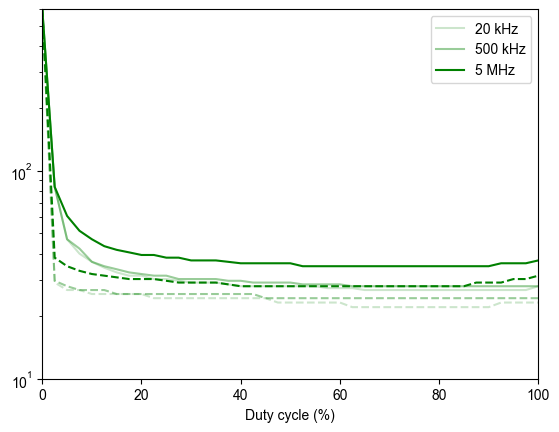

In [208]:
plt.figure()
ax = plt.subplot(1, 1, 1)
ax.plot(dc_vals * 100, th_amps_ff[0, :] / 1e3, color='green', alpha=0.2, linestyle='--')
ax.plot(dc_vals * 100, th_amps_ff[1, :] / 1e3, color='green', alpha=0.4, linestyle='--')
ax.plot(dc_vals * 100, th_amps_ff[2, :] / 1e3, color='green', alpha=1.0, linestyle='--')
ax.plot(dc_vals * 100, th_amps_ff[3, :] / 1e3, color='green', alpha=0.2, label="20 kHz")
ax.plot(dc_vals * 100, th_amps_ff[4, :] / 1e3, color='green', alpha=0.4, label="500 kHz")
ax.plot(dc_vals * 100, th_amps_ff[5, :] / 1e3, color='green', alpha=1.0, label="5 MHz")

plt.xlim(0, 100)
plt.ylim(10, 600)
plt.legend()
ax.set_yticks(np.concatenate((np.linspace(10, 100, 10), np.linspace(200, 600, 5))))
ax.set_yticklabels([])
plt.yscale('log')
plt.xlabel("Duty cycle (%)")